# Business Story

I work in the analytics department of a large german toy manufacturer. The highest selling products of the firm are math riddles and puzzles for pupils. As recent studies have shown that math riddles and puzzles may help underachieving pupils to achieve higher math grades, UK schools have started to buy such products from the firm (Plass *et al.*, 2015, Plass *et al.,* 2013, Weale, 2021). As marketing efforts have largely been non-existend due to the unfamilarity of the firm with the UK market, I am tasked to develop a model that predicts math scores for pupils at KS2 stage. As the dataset does not contain any data about the sales, I make an assumption that schools tend to buy more products if they have lower math scores. Therefore, the objective of the task is to find out a suitable model that could predict math scores and to figure out which factors could influence scores most so that our toy manufacturer can identify low achieving schools and market their products to them.

# Import Required Modules

In [ ]:
# You may need to install the following libraries
!pip install plotly==4.14.3
!pip install pgeocode
!pip install haversine
!pip install -U seaborn
!pip install lime
!pip install shap
!pip install torch

In [2]:
# DataFrame
import pandas as pd
from pandas import DataFrame
import numpy as np
from numpy import *

# CSV Saver
import tkinter as tk
from tkinter import filedialog

# Webscraping
import requests
from bs4 import BeautifulSoup
from time import sleep
from random import randint

# Visualisation and statistic method
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy, scipy.stats
import pgeocode
import haversine as hs
import plotly.express as px
from scipy.stats import shapiro
import shap

# Data Engineering
from sklearn import preprocessing

# Data splitting
from sklearn.model_selection import train_test_split

# Machine learning model
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from sklearn import metrics
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
import torch
from statsmodels.api import OLS
import statsmodels.api as sm
import lime
import lime.lime_tabular

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Module descriptions

### Plotly

plotly.py is an interactive, open-source, and browser-based graphing library for Python. Plotly is used to visualise the data for the UK on an interactive map. (https://pypi.org/project/plotly/)

### Pgeocode

pgeocode is a Python library for high performance off-line querying of GPS coordinates, region name and municipality name from postal codes. It is used to retreive the longitude and latitude of Postcodes. (https://pypi.org/project/pgeocode/)

### Haversine

This module is about calculating the distance (in various units) between two points on Earth using their latitude and longitude. It is used to calculate the distance of the schools to their relative economic centres. (https://pypi.org/project/haversine/)

### Lime

LIME is a python library that tries to solve for model interpretability by producing locally faithful explanations. It is used to increase the explainability of the Random Forest.

### Shap

SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. It is used to increase the explainability of the Random Forest and Neural Network. (https://github.com/slundberg/shap)

### Torch

Torch is an open-source machine learning library, a scientific computing framework, and a script language based on the Lua programming language. It provides a wide range of algorithms for deep learning, and uses the scripting language LuaJIT, and an underlying C implementation. It is used to build the Neuraal Networks

# 1) Loading the data

Given the size of the datasets, I directly read them in with the needed columns. Specifically, the KS2 dataset is extensive and would otherwise likely lead to the notebook crashing. Please see the next section *"Keeping Necessary Columns"* for the reasons why I chose to use the specfic columns.

In preparation for this project, several studies were considered, where the studies of Sutherland *et al,* (2015), Benton and Sutch (2014), Jadhav (2017) and Strand (2006), proved to be specifically valueable with the first two discussing modelling and predcitive methodologies and the latter two highlighting limitations of KS2 related predictive studies. I found that large datasets and increased number of variables may not necessarily increase the predictive abilities of the models used. Furthermore, the authors point out that within the KS2 datasets the writing, reading and math scores and progress may suffer from multicollinearity. As such, these studies have largely excluded such variables from their predictions (Sutherland *et al.,* 2015). In light of this, for the KS2 dataset I decided to drop all columns related to other subject areas and only to include school specific information for the predictive model.

The needed datasets may be found under my Github: https://github.com/AlexanderGH-CH/Projects

| Dataset | Variables | Columns | Description |
| :- | -: | :-: |:-: |
| England School information | URN | 0 | School unique reference number
| England School information | LA | 2 | Local authority number
| England School information | Town | 9 | School town
| England School information | SCHSTATUS | 11 | School open / closed status
| England School information | MINORGROUP | 14 | Type of school / college eg maintained school
| England School information | SCHOOLTYPE | 15 | School Type eg Voluntary Aided school
| England School information | ISPRIMARY | 16 | Does the school provide primary education? ( 0 = No, 1 = Yes)
| England School information | ISSECONDARY | 17 | Does the school provide secondary education? ( 0 = No, 1 = Yes)
| England School information | ISPOST16 | 18 | Does the school provide post 16 education? (  0 = No, 1 = Yes)
| England School information | GENDER | 21 | Indicates whether it's a mixed or single sex school
| England Census| URN | 0 | School unique reference number
| England Census| NOR | 4 | Total number of pupils on roll
| England Census| NORG | 7 | Percentage of girls on roll
| England Census| PNORB | 8 | Percentage of boys on roll
| England Census| PSENELSE | 10 | Percentage of SEN pupils with an EHC plan
| England Census| PSENELK | 12 | Percentage of eligible pupils with SEN support
| England Census| PNUMEAL | 16 | %  pupils where English not first language
| England Census| PNUMENGFL | 17 | % pupils with English first language
| England Census| PNUMFSMEVER | 21 | Percentage of pupils eligible for FSM at any time during the past 6 years
| England KS2 final| RECTYPE | 0 | Record type (1=Mainstream school; 2=Special school; 3=Local Authority; 4=National (all schools); 5=National (state-funded schools only))
| England KS2 final| URN | 3 | School unique reference number
| England KS2 final| AGERANGE | 20 | Age range
| England KS2 final| CONFEXAM | 22 | Confirmation flag that core performance information has been checked: R=No confirmation received from schools WITH RESULTS; Blank = Confirmed (or schools have no KS2)
| England KS2 final| TKS1AVERAGE  | 31 | Cohort level key stage 1 average points score
| England KS2 final| PTFSM6CLA1A  | 41 | Percentage of key stage 2 disadvantaged pupils
| England KS2 final| PTNotFSM6CLA1A  | 42 | Percentage of key stage 2 pupils who are not disadvantaged
| England KS2 final| PTMAT_EXP  | 71 | Percentage of pupils reaching the expected standard in maths
| England KS2 final| MAT_AVERAGE  | 72 | Average mathematics score
| England swf| URN  | 2 | None necessary
| England swf| School Phase  | 3 | None necessary
| England swf| Total Number of Teachers (Headcount)  | 4 | None necessary
| England swf| Total Number of Teaching Assistants (Headcount) | 5 | None necessary
| England swf| Total Number of Non Classroom-based School Support Staff, Excluding Auxiliary Staff (Headcount)  | 6 | None necessary
| England swf| Total Number of Teachers (Full-Time Equivalent)  | 7 | None necessary
| England swf| Total Number of Teaching Assistants (Full-time Equivalent)  | 8 | None necessary
| England swf| Total Number of Non Classroom-based School Support Staff, Excluding Auxiliary Staff (Full-Time Equivalent)  | 9 | None necessary
| England swf| Pupil:     Teacher Ratio  | 10 | None necessary
| England swf| Mean Gross FTE Salary of All Teachers (£s)  | 11 | None necessary

In [153]:
# Reading in the KS2 dataset
columns = [0,4,20,21,31,41,43,70,73]
df_ks2 = pd.read_csv ('england_ks2final.csv',usecols=columns, low_memory=False, sep=',')

In [154]:
# Reading in the england school information dataset
columns = [0,2,9,10,11,14,15,16,17,18,21]
df_engschoolinfo = pd.read_csv ('england_school_information.csv',usecols=columns, low_memory=False, sep=',')

In [155]:
# Reading in the england census dataset
columns = [0,4,7,8,10,12,16,17,21]
df_engcensus = pd.read_csv ('england_census.csv',usecols=columns, low_memory=False, sep=',')

In [156]:
# Reading in the england_swf dataset
columns = [2,3,4,5,6,7,8,9,10,11]
df_englandswf = pd.read_csv ('england_swf.csv',usecols=columns, low_memory=False,  sep=',')

In [157]:
# Reading in the la_and_region_codes_meta dataset
columns = [0,1,3]
df_lea = pd.read_csv ('la_and_region_codes_meta.csv',usecols=columns, low_memory=False, sep=',')
df_lea = df_lea.rename(columns={"LEA": "LA"})


# 2) Pre-processing part 1

In this section I will do the following:


1.   Pre-engineering the datasets
2.   Merge the datasets
3.   Filter the datasets
4.   Imput supplementary data
5.   Merge it with the existing data

Now this part is quite tricky. As can be seen above there are a lot of variables in the different datasets. However, they share a primary key(s) which is the URN. Hence I decide to merge the different dataframes based on this primary key using the pandas function merge (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html).

### Preliminary data engineering

For simplicity purposes I pre-engineer the data from the existing dataframes. Given the size of the subsequently merged dataset I deem this to be more readable.

In [158]:
# Transforming the not recognised columns to numeric
cols = df_ks2.columns.drop(df_ks2.columns[[2,3,5,6,7]])
df_ks2[cols] = df_ks2[cols].apply(pd.to_numeric, errors='coerce')
df_engcensus['URN'] = df_engcensus['URN'].apply(pd.to_numeric, errors='coerce')
df_lea['LA'] = df_lea['LA'].apply(pd.to_numeric, errors='coerce')

In [159]:
# Transforming the df_englandswf seperately
# otherwise the Salary is not recognised as object and left as NaN
df_englandswf[["URN", "Total Number of Teachers (Headcount)", "Total Number of Teaching Assistants (Headcount)","Total Number of Non Classroom-based School Support Staff, Excluding Auxiliary Staff (Headcount)","Total Number of Teachers (Full-Time Equivalent)","Total Number of Teaching Assistants (Full-time Equivalent)","Total Number of Non Classroom-based School Support Staff, Excluding Auxiliary Staff (Full-Time Equivalent)","Pupil:     Teacher Ratio"]] = df_englandswf[["URN", "Total Number of Teachers (Headcount)", "Total Number of Teaching Assistants (Headcount)","Total Number of Non Classroom-based School Support Staff, Excluding Auxiliary Staff (Headcount)","Total Number of Teachers (Full-Time Equivalent)","Total Number of Teaching Assistants (Full-time Equivalent)","Total Number of Non Classroom-based School Support Staff, Excluding Auxiliary Staff (Full-Time Equivalent)","Pupil:     Teacher Ratio"]].apply(pd.to_numeric,errors='coerce')

In [160]:
# Storing the orginial datatypes
orig = df_ks2.dtypes.to_dict()
orig.update(df_engschoolinfo.dtypes.to_dict())
orig.update(df_engcensus.dtypes.to_dict())
orig.update(df_englandswf.dtypes.to_dict())
orig.update(df_lea.dtypes.to_dict())

### Merging

In [161]:
# Merging the different dataframes
df_1 = df_lea.merge(df_engschoolinfo, on='LA')
df_2 = df_ks2.merge(df_1, on='URN')
df_3 = df_2.merge(df_engcensus, on='URN')
df_england_v1 = df_3.merge(df_englandswf, on='URN')
df_england_v1.head()

# Applying the orinigal datatypes to the new dataframe
df_england = df_england_v1.apply(lambda x: x.astype(orig[x.name]))

### Filter the data

Next, we need to consider the properties of the dataset (or columns) in relation to the analytics task. The following consinderations are made:
1.   We are interested in Mainstream schools as sales have been strong in schools such as special schools.
2.   Also our products are geared for *primary schools* in terms of their phase.
3.   We also only want to include schools whose core performance information has been checked.
4.   Furthermore, we only want to target schools that are open.
5.   In terms of the tye of school we want to target maintained schools only given that the analytics report may be used to target LA directly for all of their schools.
6.   Finally, community schools are the ones we want to specifically target given the success of our products at community schools in Germany.

These considerations lead to the following changes to the dataset:
1.   RECTYPE has to be *1*
2.   School Phase has to be *primary* As a result *ISPRIMARY* will be dropped as well.
3.   CONFEXAM has to be *NaN*, as blanks indicate that they have been checked
4.   SCHSTATUS has to be *open*
5.   MINORGROUP has to be *Maintained School*
6.   SCHOOLTYPE has to be set to *Community School*

In [162]:
# To filter the data, convert the required colum data types from object to string
df_england['CONFEXAM'] = df_england['CONFEXAM'].astype('str')
df_england['SCHSTATUS'] = df_england['SCHSTATUS'].astype('str')
df_england['MINORGROUP'] = df_england['MINORGROUP'].astype('str')
df_england['SCHOOLTYPE'] = df_england['SCHOOLTYPE'].astype('str')
df_england['School Phase'] = df_england['School Phase'].astype('str')
df_england = df_england.rename(columns={"School Phase": "SchoolPhase"})
#df_england.dtypes

In [163]:
# New conditional dataframe
df_new = df_england.loc[(df_england['RECTYPE'] == 1)
                        & (df_england.SCHSTATUS.str.contains('Open')) 
                        & (df_england.CONFEXAM.str.contains('nan')) 
                        & (df_england.MINORGROUP.str.contains('Maintained school'))
                        & (df_england.SCHOOLTYPE.str.contains('Community school'))
                        & (df_england.SchoolPhase.str.contains('Primary'))]
#df_new.head()

The new filtered dataframe now only contains data that can be considered for the subsequent analysis. As the columns that were used to filter the data are not used for the analysis they are dropped.

In [164]:
# Drop unnecessary columns
df_england = df_new.drop(['RECTYPE', 'ISPRIMARY','SCHSTATUS','CONFEXAM','MINORGROUP','SCHOOLTYPE','SchoolPhase'], axis = 1)
df_england.head()

,URN,AGERANGE,TKS1AVERAGE,PTFSM6CLA1A,PTNotFSM6CLA1A,PTMAT_EXP,MAT_AVERAGE,LA,LA Name,REGION NAME,TOWN,POSTCODE,ISSECONDARY,ISPOST16,GENDER,NOR,PNORG,PNORB,PSENELSE,PSENELK,PNUMEAL,PNUMENGFL,PNUMFSMEVER,Total Number of Teachers (Headcount),Total Number of Teaching Assistants (Headcount),"Total Number of Non Classroom-based School Support Staff, Excluding Auxiliary Staff (Headcount)",Total Number of Teachers (Full-Time Equivalent),Total Number of Teaching Assistants (Full-time Equivalent),"Total Number of Non Classroom-based School Support Staff, Excluding Auxiliary Staff (Full-Time Equivalent)",Pupil: Teacher Ratio,Mean Gross FTE Salary of All Teachers (£s)
1,119910.0,4-11,15.9,12%,88%,71%,103.0,855,Leicestershire,East Midlands B,Grantham,NG33 5RZ,0,0,Mixed,95.0,44.2,55.8,0.0,14.7,1.1,98.9,12.6,6.0,2.0,6.0,4.9,1.5,3.4,19.6,"£40,696"
3,119912.0,4-11,17.2,12%,88%,96%,110.0,855,Leicestershire,East Midlands B,Loughborough,LE12 5TB,0,0,Mixed,180.0,47.8,52.2,1.7,11.7,2.8,97.2,5.6,11.0,10.0,5.0,8.7,5.5,2.9,20.7,"£37,495"
4,119913.0,4-11,15.4,26%,74%,60%,100.0,855,Leicestershire,East Midlands B,Coalville,LE67 3RD,0,0,Mixed,297.0,46.8,53.2,1.7,18.9,15.8,84.2,21.5,17.0,16.0,5.0,15.1,9.9,3.5,19.7,"£38,146"
8,119916.0,4-11,17.0,19%,81%,90%,106.0,855,Leicestershire,East Midlands B,Coalville,LE67 2AH,0,0,Mixed,215.0,49.8,50.2,0.0,16.7,0.5,99.5,10.7,10.0,12.0,8.0,8.8,7.3,4.0,24.6,"£37,669"
9,119917.0,4-11,16.5,7%,93%,74%,104.0,855,Leicestershire,East Midlands B,Coalville,LE67 5DQ,0,0,Mixed,191.0,53.9,46.1,2.1,9.9,1.0,98.4,5.8,10.0,9.0,3.0,9.2,5.8,2.2,20.8,"£39,970"


## Input of supplementary data

By researching about previous studies on pupils ks2 math performance I found that a great majority of research projects do not solely base their analysis on school data but also include regional data such as *GDP per capita* (per local authority) and *local authority crime rates* (Sutherland, Ilie and Vignoles, 2015). As a result, I searched the UK Office for National Statistics database and found suitable datasets about *Regional gross domestic product local authorities* (https://www.ons.gov.uk/economy/grossdomesticproductgdp/datasets/regionalgrossdomesticproductlocalauthorities) and *regional crime* (https://www.ons.gov.uk/file?uri=/peoplepopulationandcommunity/crimeandjustice/datasets/recordedcrimedatabycommunitysafetypartnershiparea/current/crimeineandwyesep20csptables.xlsx).

### External CSV

In [165]:
# Read new excel file
df = pd.read_excel(open('regionalgrossdomesticproductgdplocalauthorities.xlsx', 'rb'),sheet_name='Table 7', usecols=['LA name', '20183'], skiprows = 1)

# I rename the "LA name" as "Town" and "20183" as "GDP/head" for readability purposes
df_GDP = df.rename(columns={'LA name': 'TOWN','20183': 'GDP per head'})
orig.update(df_GDP.dtypes.to_dict())

In [166]:
# Read new excel file
df = pd.read_excel(open('crimeineandwyesep20csptables.xlsx', 'rb'),
              sheet_name='Table C5', usecols=[5, 9], skiprows = 4, na_filter= True)

# I rename the Unnamed column as "Crime per 1000 inhabitants" for readability purposes
df_crime = df.rename(columns={'Local Authority name': 'LA Name', 'Unnamed: 9': 'Crime_per_1000'})
df_crime['Crime_per_1000'] = pd.to_numeric(df_crime['Crime_per_1000'],errors='coerce')
orig.update(df_crime.dtypes.to_dict())

### Webscraping

Furthermore, by researching the compare-school-performance website of the UK government I found a dataset containing absence data per school. As previous studies also have such data in them I decided to inlude this data as well (Sutherland, Ilie and Vignoles, 2015 and Malcolm et al., 2003). As the data was in Table format on the website (234 pages) I decided to scape it (https://www.compare-school-performance.service.gov.uk/schools-by-type?step=phase&geographic=all&region=0&phase=primary&for=abspop&schooltype=2&schoollevel=IsPrimary&orderby=abs.PERCTOT&orderdir=asc&page1). By inspecting the URL and by playing with the filters I determined that only the last element in the URL is changing.
However, the tricky part was that the URN (the unique number that identifies a School was hidden in the HTML code so I also included a specific funtion for this. Please be vary that the scraping process takes quite some time (30 to 45 min). Also to not overload the website I included a sleep pattern to allow it to respond to other requests. Given the time needed for the scraping I saved the dataset to my computer in order not to scrape the website everytime the program is run. Please see Zip file for the dataset.

In [ ]:
# **************************************
# **************************************
# SUPER LONG PROCESSING TIME!!
# **************************************
# **************************************

# ----> AT LEAST 30-45 MINUTES! <-----
    
# Initiate data storage
School_name = []
Type_of_school = []
Overall_rate_of_absence = []
Persistent_absence = []
URN = []

pages = 234
for page in range(pages):
    
    url = 'https://www.compare-school-performance.service.gov.uk/schools-by-type?step=phase&geographic=all&region=0&phase=primary&for=abspop&schooltype=2&schoollevel=IsPrimary&orderby=abs.PERCTOT&orderdir=asc&page='
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.141 Safari/537.36'}
    response = requests.get(url+str(page), headers, timeout= 10)
    
    text = response.content.decode()
    soup = BeautifulSoup(text,'lxml')
    table = soup.find('table', id='establishment-list-view')

    trs=table.find_all('tr')
    for tr in trs:
        
        URN.append(tr.get('data-urn'))
        result = tr.find_all("a", class_="result-school-link")
        for a in result:
            School_name.append(a.string)
        span = tr.find_next("span", class_="value")
        Type_of_school.append(span.get_text(strip=True))
        span1 = tr.find_previous("span", class_="value")
        if span1 is None:
            Persistent_absence.append('No Info')
        else:
            Persistent_absence.append(span1.get_text(strip=True))
        span2 = tr.find_all("span", class_="value")
        for i in range(len(span2)):
            if i ==1:
                if span2[i] is None:
                    Overall_rate_of_absence.append("None")
                else:
                    Overall_rate_of_absence.append(span2[i].get_text(strip=True))
    
            else: pass   
    
    sleep(randint(2,10))

By analysing the lists I realise that a) for every new page that is scraped the first 3 entries on the URN and b) the first 4 of Persistent_absence are *Nan* or *No Info* although they should be. Thus, the correct entries must simply be shifted upwards. However this is tricky as over 230 pages have been scraped. As such I decide to drop all None columns and No Info columns.

In [ ]:
# Clean the scraped data
URN_corrected = [x for x in URN if str(x) != 'None']
URN_corrected = list(filter(None, New1))
Pa_corrected = [x for x in Persistent_absence if str(x) != 'No Info']
absence_list = [URN_corrected,School_name,Type_of_school,Overall_rate_of_absence,Pa_corrected]
df_absence = pd.DataFrame(absence_list).transpose()
df_absence.columns = ['URN','School_Name','Type_of_school','Overall_rate_of_absence', 'Persistent_absence']
df_absence.head(20)

To make the saving process easier I created a simple interface with tkinter.

In [ ]:
# Filesave interface
root= tk.Tk()

canvas1 = tk.Canvas(root, width = 300, height = 300, bg = 'lightsteelblue2', relief = 'raised')
canvas1.pack()

def exportCSV ():
    global df_absence
    
    export_file_path = filedialog.asksaveasfilename(defaultextension='.csv')
    df_absence.to_csv (export_file_path, index = False, header=True)

saveAsButton_CSV = tk.Button(text='Export CSV', command=exportCSV, bg='green', fg='white', font=('helvetica', 12, 'bold'))
canvas1.create_window(150, 150, window=saveAsButton_CSV)

root.mainloop()

In order to avoid having to run the code everytime I use the datafile saved. The website also provides a file. You may choose either. However, I found the one from the website to be cleaners (no missing entries, no duplicates). Nevertheless, there is no option in the one from the website to choose the school type. For the rest of this project I will use the one provided from the website for consitency/ repeatability reasons.

In [167]:
# Load the csv file
df_absload = pd.read_csv ('2018-2019_england_abs.csv',low_memory=False,sep=',')
#df_absload['Type_of_school'] = df_absload['Type_of_school'].astype('str')
#df_abs1= df_absload.loc[((df_absload.Type_of_school.str.contains('Maintained school')))]
df_absence = df_absload.drop(['LA', 'ESTAB'], axis = 1)
orig.update(df_absence.dtypes.to_dict())
#df_absence

### Merging the datasets

In [168]:
# Merging the different dataframes
df_1 = df_england.merge(df_crime, on='LA Name')
df_2 = df_1.merge(df_GDP, on='TOWN')
df_3 = df_2.merge(df_absence, on='URN')
#df_england = df_3

# Applying the orinigal datatypes to the new dataframe
df_england = df_3.apply(lambda x: x.astype(orig[x.name]))

# To check the different datatypes
df_england.dtypes

URN                                                                                                           float64
AGERANGE                                                                                                       object
TKS1AVERAGE                                                                                                   float64
PTFSM6CLA1A                                                                                                    object
PTNotFSM6CLA1A                                                                                                 object
PTMAT_EXP                                                                                                      object
MAT_AVERAGE                                                                                                   float64
LA                                                                                                              int64
LA Name                                                 

# 3) Pre-Processing part 2

In this section I will do the following;



1.   Handle the missing data
2.   Account for the location
3.   Engineering the data for the exploratory data analysis and the predictive modelling



## Handling of missing data

According to  https://www.gov.uk/guidance/understanding-scaled-scores-at-key-stage-2, the scores of KS2 tests  categorised into 2 groups. They are:

1.   Pupils scoring at least a scaled score of 100 will have met the expected 
standard in the test 
2.   A pupil awarded a scaled score of 99 or less has not met the expected standard in the test

Where the minimum scaled score is 80 and the maximum scaled score 120.

So, the categories of math-scores in this case are in line with the above scale.

In [169]:
# Check for null values
#print(df_england.isnull().sum())

In [170]:
# Remove possible duplicates that might have emerged from the merging
df_england = df_england.drop_duplicates(subset=['URN'])
# print(df_england.isnull().sum())

In [171]:
# Check if null values are left
df1 = df_england[df_england.isna().any(axis=1)]
#df1

By observing the dataset I find out that the crime data for the *Greater Manchester* area is not provided. The Office for National Statistics (2020,p.3) states that: "Following the implementation of a new IT system in July 2019, Greater Manchester Police have been previously unable to supply data from the period of July 2019 to March 2020." As this area is comprised of Bolton, Bury, Manchester, Oldham, Rochdale, Salford, Stockport, Tameside, Trafford, Wigan with a total of 2.8 million inhabitants excluding it would prohibit a substantiated analysis (Office for National Statistics, 2020). As a result I decide to remove the column entirely. 

In [172]:
# Drop column
df_england = df_england.drop(['Crime_per_1000'], axis=1)
# print(df_england.isnull().sum())

By inspecting the missing TOWN and by revisting the csv file I find out that the missing Town is *Immingham*.

In [173]:
# Handle missing element
#print(df_england[df_england['TOWN'].isnull()])
df_england['TOWN'] = df_england['TOWN'].fillna('Immingham')
#print(df_england.isnull().sum())

By inspecting the missing values for *TKS1AVERAGE*, *PTFSM6CLA1A*, *PTNotFSM6CLA1A*, *PTMAT_EXP*, *MAT_AVERAGE* I realise that no information for them is provided in the CSV, thus no merging error has occurred. Additionally they all stems from the same five schools. These are located in Wokingham, Kingston upon Thames, Birmingham, Luton and Milton Keynes. As I have other schools from this area and given the proportionally small number of missing values I decide to drop these rows.

In [174]:
# Drop column
#print(df_england[df_england['TKS1AVERAGE'].isnull()])
df_england = df_england[df_england['TKS1AVERAGE'].notna()]

By inspecting the the missing rows I realise that the dataset df_englandswf doesn't contain any information (NaN for these two schools. Thus, I drop these rows.

In [175]:
# Drop rows
#print(df_england[df_england['Total Number of Teachers (Headcount)'].isnull()])
df_england = df_england[df_england['Total Number of Teachers (Headcount)'].notna()]
#print(df_england.isnull().sum())

After looking into the missing GDP data, I find that the GDP per head for *Noth Lincolnshire* amounts to 35,906, thus I replace the missing NaN value with this amount.

In [176]:
# Replace missing element
#print(df_england[df_england['GDP per head'].isnull()])
df_england['GDP per head'] = df_england['GDP per head'].fillna(35906)
#print(df_england.isnull().sum())

In summary, the missing values were mostly due to incomplete data in the orginal datasets. Only in the instances of *GDP per head* and *TOWN* was there an error due to the merging of the different datasets.

In [177]:
# Check for null values
#print(df_england.isnull().sum())

## Accounting for the location

Location may play an imporant factor in our decision where to market our product as well as in terms of school performance. To account for the location of the schools I consider the *LA*, *POSTCODE*, *LA Name* as well as the Region.

In [178]:
# Check for unique Towns
amount = 0
Towns = df_england.TOWN.unique()
for town in Towns:
    amount = amount +1
print(amount)
print(Towns)

61
['Leicester' 'Leeds' 'Bradford' 'Wakefield' 'Gateshead' 'Sunderland'
 'Stoke-on-Trent' 'Swindon' 'Reading' 'Slough' 'Wokingham' 'Hartlepool'
 'Middlesbrough' 'Stockton-on-Tees' 'Hackney' 'Islington' 'Bromley'
 'Barnet' 'Bexley' 'Harrow' 'Croydon' 'Enfield' 'Peterborough'
 'Warrington' 'York' 'Selby' 'Immingham' 'Hounslow' 'Kingston upon Thames'
 'Sutton' 'Bolton' 'Blackpool' 'Birmingham' 'Coventry' 'Dudley' 'Walsall'
 'Luton' 'Bedford' 'Milton Keynes' 'Nottingham' 'Derby' 'Darlington'
 'Plymouth' 'Solihull' 'Wolverhampton' 'Liverpool' 'Wigan' 'Wirral'
 'Newport' 'Bury' 'Manchester' 'Oldham' 'Rochdale' 'Salford' 'Stockport'
 'Barnsley' 'Rotherham' 'Sheffield' 'Doncaster' 'Portsmouth' 'Southampton']


In [179]:
# Check for unique LA Names
df_england = df_england.rename(columns={"LA Name": "LA_Name"})
amount = 0
LA_Names = df_england.LA_Name.unique()
for name in LA_Names:
    amount = amount+1
print(amount)
print(LA_Names)

78
['Leicester' 'Leeds' 'Bradford' 'Wakefield' 'Kirklees' 'Gateshead'
 'Sunderland' 'South Tyneside' 'Stoke-on-Trent' 'Cheshire East' 'Swindon'
 'Windsor and Maidenhead' 'West Berkshire' 'Reading' 'Wokingham' 'Slough'
 'Hartlepool' 'County Durham' 'Middlesbrough' 'Stockton-on-Tees' 'Hackney'
 'Islington' 'Lewisham' 'Barnet' 'Enfield' 'Bexley' 'Brent' 'Harrow'
 'Croydon' 'Peterborough' 'Halton' 'Warrington' 'Wigan'
 'East Riding of Yorkshire' 'York' 'North Lincolnshire' 'Hounslow'
 'Kingston upon Thames' 'Sutton' 'Blackburn with Darwen' 'Bolton'
 'Blackpool' 'Birmingham' 'Sandwell' 'Solihull' 'Walsall' 'Coventry'
 'Dudley' 'Luton' 'Central Bedfordshire' 'Bedford' 'Milton Keynes'
 'Nottingham' 'Derby' 'Darlington' 'Plymouth' 'Wolverhampton' 'Knowsley'
 'Liverpool' 'Sefton' 'St. Helens' 'Wirral' 'Telford and Wrekin'
 'Isle of Wight' 'Bury' 'Manchester' 'Oldham' 'Rochdale' 'Salford'
 'Tameside' 'Trafford' 'Stockport' 'Barnsley' 'Rotherham' 'Sheffield'
 'Doncaster' 'Portsmouth' 'Southampton

The dataframe contains a total of 60 different *TOWNS* and 77 different *LA_Names*. As for the subsequent predictive modelling, these variables who need to be transformed into binary variables (0,1) where each *TOWN* or *LA_Name* would get its own column. This would increase the computational needs. Thus, I look for another way to acount for the location.

In [180]:
# Check for unique LA numbers
amount = 0
LAs = df_england.LA.unique()
for la in LAs:
    amount = amount+1
print(amount)
print(LAs)

78
[856 383 380 384 382 390 394 393 861 895 866 868 869 870 872 871 805 840
 806 808 204 206 209 302 308 303 304 310 306 874 876 877 359 811 816 813
 313 314 319 889 350 890 330 333 334 335 331 332 821 823 822 826 892 831
 841 879 336 340 341 343 342 344 894 921 351 352 353 354 355 357 358 356
 370 372 373 371 851 852]


In [181]:
# Check for unique postcodes
amount = 0
PSTC = df_england.POSTCODE.unique()
for code in PSTC:
    amount = amount+1
print(amount)
print(PSTC)

1015
['LE3 1FF' 'LE5 3HH' 'LE4 6AZ' ... 'SO16 8BY' 'SO16 6AY' 'SO16 4AS']


In [182]:
# Check for unique region names
df_england = df_england.rename(columns={"REGION NAME": "REGION_NAME"})
amount = 0
REGION_NAMES = df_england.REGION_NAME.unique()
for region in REGION_NAMES:
    amount = amount+1
print(amount)
print(REGION_NAMES)

21
['East Midlands B' 'South and West Yorkshire' 'North East B'
 'West Midlands A' 'North West C' 'South West B' 'South East A'
 'North East A' 'London East' 'London Central' 'London North'
 'London West' 'London South' 'East of England A' 'North West B'
 'North Yorkshire and The Humber' 'North West A' 'West Midlands C'
 'East Midlands A' 'South West A' 'South East B']


By considering the *LA* number as well as the *POSTCODE* I get similar results with postcodes being unique for almost every entry in the dataframe. However, Zip Codes and LA codes are hierarchical which inhibits the prediction for new ones. On Stackexchange I find out that the use of Latitude and longitude of the ZIP code might be useful when working with tree based models. Also, Ray (2015) considers how to deal with ZIP codes and suggests that to reduce the level of complexity one might use OneHotEncoding for their region. Furthemore, by reading an article by Velasco (2019) I discover another way of dealig with locational data such as the distance of the ZIP code to major economic centres. As we want to market our products this might be an interesting feature to include. (https://stats.stackexchange.com/questions/94902/how-to-represent-geography-or-zip-code-in-machine-learning-model-or-recommender)

I decide to create three additional columns: (1) Longitude, (2) latitude, (3) distance from epicentre.

In [183]:
# Create additional columns
nomi = pgeocode.Nominatim('GB')
def long_lat(PCODE_list):
  """Retreive the longitude and latitude
  of a postcode"""
  df_lat =[]
  df_long = []
  for i in PCODE_list:
      x = nomi.query_postal_code(i)[9]
      df_lat.append(x)
      y = nomi.query_postal_code(i)[10]
      df_long.append(y)
  return df_lat, df_long

# Retreiving the longitude and latitude columns
PCODE_list = df_england['POSTCODE'].tolist()
df_lat, df_long = long_lat(PCODE_list)

In [184]:
# Creating a new column for the longitude and latitude
df_england = df_england.assign(latitude =df_lat)
df_england = df_england.assign(longitude = df_long)

In [185]:
# check for missing values
print(df_england.isnull().sum())

URN                                                                                                           0
AGERANGE                                                                                                      0
TKS1AVERAGE                                                                                                   0
PTFSM6CLA1A                                                                                                   0
PTNotFSM6CLA1A                                                                                                0
PTMAT_EXP                                                                                                     0
MAT_AVERAGE                                                                                                   0
LA                                                                                                            0
LA_Name                                                                                                 

Some elements in the Persistent absence column contain SUPP values which are defined as: "Suppressed: in certain circumstances we will suppress an establishment's data. This is usually when there are 5 or fewer pupils or students covered by the measure (29 for apprenticeships measures). We avoid making these figures public to protect individual privacy. We may also suppress data on a case-by-case basis." As a result I delete the rows that contain such values.

In [186]:
# Get the index of rows that contain SUPP values
i = df_england[((df_england.PPERSABS10 == 'SUPP'))].index
df_england = df_england.drop(i)

In [187]:
# Transformt the column to numeric
df_england['PPERSABS10'] = df_england['PPERSABS10'].apply(pd.to_numeric)

In [188]:
# Lookup the rows with missing values
df_england[df_england.isnull().any(axis=1)]

,URN,AGERANGE,TKS1AVERAGE,PTFSM6CLA1A,PTNotFSM6CLA1A,PTMAT_EXP,MAT_AVERAGE,LA,LA_Name,REGION_NAME,TOWN,POSTCODE,ISSECONDARY,ISPOST16,GENDER,NOR,PNORG,PNORB,PSENELSE,PSENELK,PNUMEAL,PNUMENGFL,PNUMFSMEVER,Total Number of Teachers (Headcount),Total Number of Teaching Assistants (Headcount),"Total Number of Non Classroom-based School Support Staff, Excluding Auxiliary Staff (Headcount)",Total Number of Teachers (Full-Time Equivalent),Total Number of Teaching Assistants (Full-time Equivalent),"Total Number of Non Classroom-based School Support Staff, Excluding Auxiliary Staff (Full-Time Equivalent)",Pupil: Teacher Ratio,Mean Gross FTE Salary of All Teachers (£s),GDP per head,PERCTOT,PPERSABS10,latitude,longitude
785,105405.0,3-11,14.5,64%,36%,75%,104.0,352,Manchester,North West B,Manchester,M9 7BX,0,0,Mixed,467.0,47.3,52.7,2.1,21.2,19.7,79.4,52.0,21.0,21.0,8.0,21.0,19.9,5.9,22.2,"£37,999",44781.0,4.3,11.5,NaN,NaN
787,105412.0,3-11,14.7,95%,5%,55%,100.0,352,Manchester,North West B,Manchester,M9 6TG,0,0,Mixed,431.0,45.0,55.0,0.9,19.0,21.1,78.7,59.9,22.0,22.0,3.0,21.6,22.0,3.0,20.0,"£35,733",44781.0,4.3,11.0,NaN,NaN
793,105428.0,3-11,15.2,63%,37%,85%,105.0,352,Manchester,North West B,Manchester,M9 4HH,0,0,Mixed,477.0,52.0,48.0,0.4,23.1,37.5,62.5,51.8,29.0,28.0,4.0,27.4,27.1,4.0,17.4,"£36,555",44781.0,3.8,8.0,NaN,NaN
805,105470.0,3-11,15.7,51%,49%,77%,106.0,352,Manchester,North West B,Manchester,M9 8QP,0,0,Mixed,468.0,48.3,51.7,2.6,8.5,23.1,75.9,36.0,22.0,32.0,7.0,21.8,29.1,5.5,21.5,"£34,597",44781.0,3.7,7.2,NaN,NaN
991,131082.0,3-11,15.7,54%,46%,78%,104.0,373,Sheffield,South and West Yorkshire,Sheffield,S5 7HL,0,0,Mixed,497.0,45.5,54.5,0.8,27.0,16.5,83.5,53.4,25.0,28.0,8.0,21.1,21.3,5.8,22.3,"£40,897",24608.0,5.0,12.6,NaN,NaN


In [189]:
# Check if one Postcode is not containted
'M9 7BX' in PCODE_list
'M9 6TG' in PCODE_list
'M9 4HH' in PCODE_list
'M9 8QP' in PCODE_list
'S5 7HL' in PCODE_list

True

In [190]:
# Check for the missing values with function
df_lat1 =[]
df_long1 = []
PCODE_list1 = ['M9 7BX','M9 6TG','M9 4HH','M9 8QP','S5 7HL']
for i in PCODE_list1:
    x = nomi.query_postal_code(i)[9]
    df_lat1.append(x)
    y = nomi.query_postal_code(i)[10]
    df_long1.append(y)

In [191]:
# See if missing values accounted for 
print(df_lat1,df_long1)

[nan, nan, nan, nan, nan] [nan, nan, nan, nan, nan]


It seems like the query cannot find the longitude and latitude of these Postcodes. Hence, I look them up under: https://www.freemaptools.com/convert-uk-postcode-to-lat-lng.htm. I get the following results:
53.52397,-2.19018
53.52945,-2.19644
53.51351,-2.20252
53.52271,-2.22377
53.41065,-1.47401

In [192]:
# Handle the missing elements
df_england.at[785, 'latitude'] = 53.52397
df_england.at[785, 'longitude'] = -2.19018

df_england.at[787, 'latitude'] = 53.52945
df_england.at[787, 'longitude'] = -2.19644

df_england.at[793, 'latitude'] = 53.51351
df_england.at[793, 'longitude'] = -2.20252

df_england.at[805, 'latitude'] = 53.52271
df_england.at[805, 'longitude'] = -2.22377

df_england.at[991, 'latitude'] = 53.41065
df_england.at[991, 'longitude'] = -1.47401

In [193]:
# Check if the values have been replaced
#df_england[df_england.isnull().any(axis=1)]

For the purpose of analysis the relative distance to the four economic epicentres located in Manchester, Birmingham, London and Leeds are considered (Brookings Institution, 2018). It is herein assumed that these are representative. For this purpose the haversine module is used. (Source: https://pypi.org/project/haversine/)

In [194]:
# I lookup the latitude and longitude of the respective centres with their Postcode to ensure consistency
df_lat2= []
df_long2= []
PCODE_list2 = ['M1','B1','SW7','BD11']
for i in PCODE_list2:
    x = nomi.query_postal_code(i)[9]
    df_lat2.append(x)
    y = nomi.query_postal_code(i)[10]
    df_long2.append(y)

In [195]:
# Check latitude correctness
df_lat2

[53.4809, 52.4814, 51.4944, 53.746]

In [196]:
# Check longitude correctness
df_long2

[-2.2374, -1.8998, -0.17628333333333335, -1.6770333333333332]

In [197]:
# Create economic centres (long, lat)
Manchester = (df_lat2[0],df_long2[0]) # lat and long
Brimingham =  (df_lat2[1],df_long2[1])
London = (df_lat2[2],df_long2[2])
Leeds = (df_lat2[3],df_long2[3])
Leeds

(53.746, -1.6770333333333332)

In [198]:
# Test (Leicester) -successful
test_ex = (52.6466,-1.186967)
print(hs.haversine(test_ex,Manchester, unit='km'), hs.haversine(Brimingham, test_ex, unit='km'),hs.haversine(London, test_ex, unit='km'),hs.haversine(Leeds, test_ex, unit='km'))

116.32830979121097 51.564924824325644 145.55276917665708 126.53083177658563


In [199]:
# Creation new columns (long, lat and them together)
df_lat = df_england['latitude'].tolist()
df_long = df_england['longitude'].tolist()
df_england['lat_long'] = tuple(zip(df_lat, df_long))

In [200]:
# Calculate the economic distance
Manchester_distances =[]
for i in df_england['lat_long']:
    Manchester_distances.append(hs.haversine((Manchester),(i), unit='km'))
df_england['distance_from_manchester'] = pd.Series(Manchester_distances)

Brimingham_distances = []
for i in df_england['lat_long']:
    Brimingham_distances.append(hs.haversine((Brimingham),(i), unit='km'))
df_england['distance_from_birmingham'] = pd.Series(Brimingham_distances)

London_distances = []
for i in df_england['lat_long']:
    London_distances.append(hs.haversine((London),(i), unit='km'))
df_england['distance_from_london'] = pd.Series(London_distances)

Leeds_distances = []
for i in df_england['lat_long']:
    Leeds_distances.append(hs.haversine((Leeds),(i), unit='km'))
df_england['distance_from_leeds'] = pd.Series(Leeds_distances)

In [201]:
# Show how the df looks like
df_england

,URN,AGERANGE,TKS1AVERAGE,PTFSM6CLA1A,PTNotFSM6CLA1A,PTMAT_EXP,MAT_AVERAGE,LA,LA_Name,REGION_NAME,TOWN,POSTCODE,ISSECONDARY,ISPOST16,GENDER,NOR,PNORG,PNORB,PSENELSE,PSENELK,PNUMEAL,PNUMENGFL,PNUMFSMEVER,Total Number of Teachers (Headcount),Total Number of Teaching Assistants (Headcount),"Total Number of Non Classroom-based School Support Staff, Excluding Auxiliary Staff (Headcount)",Total Number of Teachers (Full-Time Equivalent),Total Number of Teaching Assistants (Full-time Equivalent),"Total Number of Non Classroom-based School Support Staff, Excluding Auxiliary Staff (Full-Time Equivalent)",Pupil: Teacher Ratio,Mean Gross FTE Salary of All Teachers (£s),GDP per head,PERCTOT,PPERSABS10,latitude,longitude,lat_long,distance_from_manchester,distance_from_birmingham,distance_from_london,distance_from_leeds
0,132211.0,3-11,15.4,44%,56%,85%,108.0,856,Leicester,East Midlands B,Leicester,LE3 1FF,0,0,Mixed,597.0,46.7,53.3,0.7,15.6,31.3,68.5,33.3,32.0,45.0,6.0,30.0,26.7,5.4,19.2,"£35,646",25915.0,4.1,9.0,52.6466,-1.186967,"(52.6466, -1.1869666666666667)",116.328323,51.564946,145.552758,126.530838
1,119999.0,7-11,14.7,11%,89%,80%,106.0,856,Leicester,East Midlands B,Leicester,LE5 3HH,0,0,Mixed,359.0,51.8,48.2,0.8,19.8,89.1,10.9,18.4,19.0,16.0,4.0,16.3,11.7,4.0,22.1,"£40,630",25915.0,3.8,6.2,52.6474,-1.086500,"(52.6474, -1.0865)",120.428351,57.988428,142.502447,128.335239
2,120003.0,7-11,17.3,22%,78%,84%,106.0,856,Leicester,East Midlands B,Leicester,LE4 6AZ,0,0,Mixed,490.0,45.5,54.5,0.2,9.6,88.4,11.6,24.1,25.0,24.0,5.0,21.9,13.3,4.5,22.4,"£38,925",25915.0,4.3,11.8,52.6667,-1.108733,"(52.6667, -1.1087333333333331)",117.817745,57.291057,145.091025,125.838299
3,120005.0,3-11,15.4,17%,83%,88%,107.0,856,Leicester,East Midlands B,Leicester,LE5 5LL,0,0,Mixed,366.0,47.8,52.2,3.8,7.7,96.2,3.8,16.2,16.0,37.0,6.0,14.7,24.6,4.7,23.3,"£36,117",25915.0,4.8,9.2,52.6474,-1.086500,"(52.6474, -1.0865)",120.428351,57.988428,142.502447,128.335239
4,120006.0,3-11,16.4,31%,69%,81%,106.0,856,Leicester,East Midlands B,Leicester,LE2 8LP,0,0,Mixed,502.0,47.2,52.8,1.2,15.9,11.8,88.0,24.0,22.0,29.0,7.0,20.1,20.0,4.8,24.9,"£38,667",25915.0,4.0,8.3,52.5853,-1.116717,"(52.5853, -1.1167166666666668)",124.628275,54.212727,137.299101,134.359191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1021,116123.0,4-11,14.6,64%,36%,75%,103.0,852,Southampton,South East B,Southampton,SO16 9BB,0,0,Mixed,205.0,44.9,55.1,2.9,31.2,6.3,93.7,53.7,11.0,17.0,3.0,9.8,11.7,2.9,20.9,"£36,846",33707.0,3.4,4.4,50.9448,-1.431825,"(50.9448, -1.431825)",NaN,NaN,NaN,NaN
1022,116138.0,4-11,16.3,28%,72%,88%,106.0,852,Southampton,South East B,Southampton,SO16 8FD,0,0,Mixed,410.0,45.9,54.1,2.0,13.9,15.6,84.4,22.4,25.0,18.0,6.0,19.6,9.6,4.3,20.9,"£40,477",33707.0,3.2,5.0,50.9448,-1.431825,"(50.9448, -1.431825)",NaN,NaN,NaN,NaN
1023,116253.0,7-11,16.2,45%,55%,75%,105.0,852,Southampton,South East B,Southampton,SO16 8BY,0,0,Mixed,374.0,46.3,53.7,1.3,10.4,17.6,82.4,41.4,21.0,9.0,4.0,18.6,7.0,2.7,20.1,"£37,138",33707.0,4.9,11.7,50.9448,-1.431825,"(50.9448, -1.431825)",NaN,NaN,NaN,NaN
1024,116262.0,2-11,15.0,32%,68%,92%,106.0,852,Southampton,South East B,Southampton,SO16 6AY,0,0,Mixed,469.0,46.7,53.3,1.7,21.5,38.4,61.6,31.6,25.0,25.0,8.0,23.8,19.2,5.0,19.0,"£33,728",33707.0,4.7,12.3,50.9448,-1.431825,"(50.9448, -1.431825)",NaN,NaN,NaN,NaN


In [202]:
# Creation of the new column for distance from the epicenter
df_england['distance_from_epicenter'] = df_england[['distance_from_manchester','distance_from_birmingham','distance_from_london','distance_from_leeds']].min(axis=1)

Lastly I create another column that contains the shortest distance/proximity to an epicentre. After this step we discard the columns: *LA*, *LA_Name*, *TOWN*,*POSTCODE* and *lat_long* as they are not of use for the predictive modelling anymore.

In [203]:
# Show how the df looks like
df_england

,URN,AGERANGE,TKS1AVERAGE,PTFSM6CLA1A,PTNotFSM6CLA1A,PTMAT_EXP,MAT_AVERAGE,LA,LA_Name,REGION_NAME,TOWN,POSTCODE,ISSECONDARY,ISPOST16,GENDER,NOR,PNORG,PNORB,PSENELSE,PSENELK,PNUMEAL,PNUMENGFL,PNUMFSMEVER,Total Number of Teachers (Headcount),Total Number of Teaching Assistants (Headcount),"Total Number of Non Classroom-based School Support Staff, Excluding Auxiliary Staff (Headcount)",Total Number of Teachers (Full-Time Equivalent),Total Number of Teaching Assistants (Full-time Equivalent),"Total Number of Non Classroom-based School Support Staff, Excluding Auxiliary Staff (Full-Time Equivalent)",Pupil: Teacher Ratio,Mean Gross FTE Salary of All Teachers (£s),GDP per head,PERCTOT,PPERSABS10,latitude,longitude,lat_long,distance_from_manchester,distance_from_birmingham,distance_from_london,distance_from_leeds,distance_from_epicenter
0,132211.0,3-11,15.4,44%,56%,85%,108.0,856,Leicester,East Midlands B,Leicester,LE3 1FF,0,0,Mixed,597.0,46.7,53.3,0.7,15.6,31.3,68.5,33.3,32.0,45.0,6.0,30.0,26.7,5.4,19.2,"£35,646",25915.0,4.1,9.0,52.6466,-1.186967,"(52.6466, -1.1869666666666667)",116.328323,51.564946,145.552758,126.530838,51.564946
1,119999.0,7-11,14.7,11%,89%,80%,106.0,856,Leicester,East Midlands B,Leicester,LE5 3HH,0,0,Mixed,359.0,51.8,48.2,0.8,19.8,89.1,10.9,18.4,19.0,16.0,4.0,16.3,11.7,4.0,22.1,"£40,630",25915.0,3.8,6.2,52.6474,-1.086500,"(52.6474, -1.0865)",120.428351,57.988428,142.502447,128.335239,57.988428
2,120003.0,7-11,17.3,22%,78%,84%,106.0,856,Leicester,East Midlands B,Leicester,LE4 6AZ,0,0,Mixed,490.0,45.5,54.5,0.2,9.6,88.4,11.6,24.1,25.0,24.0,5.0,21.9,13.3,4.5,22.4,"£38,925",25915.0,4.3,11.8,52.6667,-1.108733,"(52.6667, -1.1087333333333331)",117.817745,57.291057,145.091025,125.838299,57.291057
3,120005.0,3-11,15.4,17%,83%,88%,107.0,856,Leicester,East Midlands B,Leicester,LE5 5LL,0,0,Mixed,366.0,47.8,52.2,3.8,7.7,96.2,3.8,16.2,16.0,37.0,6.0,14.7,24.6,4.7,23.3,"£36,117",25915.0,4.8,9.2,52.6474,-1.086500,"(52.6474, -1.0865)",120.428351,57.988428,142.502447,128.335239,57.988428
4,120006.0,3-11,16.4,31%,69%,81%,106.0,856,Leicester,East Midlands B,Leicester,LE2 8LP,0,0,Mixed,502.0,47.2,52.8,1.2,15.9,11.8,88.0,24.0,22.0,29.0,7.0,20.1,20.0,4.8,24.9,"£38,667",25915.0,4.0,8.3,52.5853,-1.116717,"(52.5853, -1.1167166666666668)",124.628275,54.212727,137.299101,134.359191,54.212727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1021,116123.0,4-11,14.6,64%,36%,75%,103.0,852,Southampton,South East B,Southampton,SO16 9BB,0,0,Mixed,205.0,44.9,55.1,2.9,31.2,6.3,93.7,53.7,11.0,17.0,3.0,9.8,11.7,2.9,20.9,"£36,846",33707.0,3.4,4.4,50.9448,-1.431825,"(50.9448, -1.431825)",NaN,NaN,NaN,NaN,NaN
1022,116138.0,4-11,16.3,28%,72%,88%,106.0,852,Southampton,South East B,Southampton,SO16 8FD,0,0,Mixed,410.0,45.9,54.1,2.0,13.9,15.6,84.4,22.4,25.0,18.0,6.0,19.6,9.6,4.3,20.9,"£40,477",33707.0,3.2,5.0,50.9448,-1.431825,"(50.9448, -1.431825)",NaN,NaN,NaN,NaN,NaN
1023,116253.0,7-11,16.2,45%,55%,75%,105.0,852,Southampton,South East B,Southampton,SO16 8BY,0,0,Mixed,374.0,46.3,53.7,1.3,10.4,17.6,82.4,41.4,21.0,9.0,4.0,18.6,7.0,2.7,20.1,"£37,138",33707.0,4.9,11.7,50.9448,-1.431825,"(50.9448, -1.431825)",NaN,NaN,NaN,NaN,NaN
1024,116262.0,2-11,15.0,32%,68%,92%,106.0,852,Southampton,South East B,Southampton,SO16 6AY,0,0,Mixed,469.0,46.7,53.3,1.7,21.5,38.4,61.6,31.6,25.0,25.0,8.0,23.8,19.2,5.0,19.0,"£33,728",33707.0,4.7,12.3,50.9448,-1.431825,"(50.9448, -1.431825)",NaN,NaN,NaN,NaN,NaN


In [204]:
# Check for empty rows
df_empty = df_england[df_england.isnull().any(axis=1)]

In [205]:
# Account for the missing elemets
indexes = df_empty.index
for i in indexes:
    df_england.at[i, 'distance_from_manchester'] = hs.haversine((Manchester),(df_england.at[i,'lat_long']), unit='km')
    df_england.at[i, 'distance_from_birmingham'] = hs.haversine((Brimingham),(df_england.at[i,'lat_long']), unit='km')
    df_england.at[i, 'distance_from_london'] = hs.haversine((London),(df_england.at[i,'lat_long']), unit='km')
    df_england.at[i, 'distance_from_leeds'] = hs.haversine((Leeds),(df_england.at[i,'lat_long']), unit='km')
    df_england.at[i,'distance_from_epicenter'] = min([df_england.at[i,'distance_from_manchester'],df_england.at[i,'distance_from_birmingham'],df_england.at[i,'distance_from_london'],df_england.at[i,'distance_from_leeds']])

In [206]:
# Check if there are any missing elements left
df_england[df_england.isnull().any(axis=1)]

,URN,AGERANGE,TKS1AVERAGE,PTFSM6CLA1A,PTNotFSM6CLA1A,PTMAT_EXP,MAT_AVERAGE,LA,LA_Name,REGION_NAME,TOWN,POSTCODE,ISSECONDARY,ISPOST16,GENDER,NOR,PNORG,PNORB,PSENELSE,PSENELK,PNUMEAL,PNUMENGFL,PNUMFSMEVER,Total Number of Teachers (Headcount),Total Number of Teaching Assistants (Headcount),"Total Number of Non Classroom-based School Support Staff, Excluding Auxiliary Staff (Headcount)",Total Number of Teachers (Full-Time Equivalent),Total Number of Teaching Assistants (Full-time Equivalent),"Total Number of Non Classroom-based School Support Staff, Excluding Auxiliary Staff (Full-Time Equivalent)",Pupil: Teacher Ratio,Mean Gross FTE Salary of All Teachers (£s),GDP per head,PERCTOT,PPERSABS10,latitude,longitude,lat_long,distance_from_manchester,distance_from_birmingham,distance_from_london,distance_from_leeds,distance_from_epicenter


In [207]:
# Drop unnecessary columns
df_england = df_england.drop(['LA', 'LA_Name','lat_long','distance_from_manchester','distance_from_birmingham','distance_from_london','distance_from_leeds'], axis = 1)

In [208]:
# The location has been accounted for using the longitude and latitude as well as distance from epicentre.
# Hence, the Region_Name is dropped. 
df_england = df_england.drop(["REGION_NAME"], axis = 1)

## Data Engineering

The dataset (df_england) contains a lot of data which is not in the right format (string instead of float/int) or that is to be processed such as percentages, £, ranges (i.e., 3-7).

As a result the following columns need to be changed:
1. AGERANGE --> display the actual range numerically. I.e., when 3-11, then 9 (3 and 11 are also represented thus 11-3+1 = 9)
2. PTFSM6CLA1A --> from percentage to numerical
3. PTNotFSM6CLA1A --> from percentage to numerical
4. PTMAT_EXP --> from percentage to numerical
5. GENDER --> will be dropped as all schools contained are mixed. URN will be dropped too. 
6. Mean Gross FTE Salary of All Teachers (£s) --> remove the £ and the comma
7. PPERSABS10 --> Change from string to numerical. Additionally, deal with the SUPP values.
8. We want to target schools with expected mathematics scores of 75 or less.


In [209]:
# Transforming all the percentages
# For this purpose I leverage regular expression
df_england['PTFSM6CLA1A'] = df_england['PTFSM6CLA1A'].str.replace(r'\D',"").apply(pd.to_numeric)
df_england['PTNotFSM6CLA1A'] = df_england['PTNotFSM6CLA1A'].str.replace(r'\D',"").apply(pd.to_numeric)
df_england['PTMAT_EXP'] = df_england['PTMAT_EXP'].str.replace(r'\D',"").apply(pd.to_numeric)

In [210]:
# Transforming the £ columns
# For this purpose I leverage regular expression
# Importantly there needs to be an additional argument for errors as I have replaced an NaN value with an non £-containing value
df_england['Mean Gross FTE Salary of All Teachers (£s)'] = df_england['Mean Gross FTE Salary of All Teachers (£s)'].str.replace(',', '')
df_england['Mean Gross FTE Salary of All Teachers (£s)'] = df_england['Mean Gross FTE Salary of All Teachers (£s)'].str.replace(r'£', '').apply(pd.to_numeric,errors='ignore')

In [211]:
# Dropping the gender column
df_england = df_england.drop(['GENDER'], axis=1)
# df_england = df_england.drop(['ISPOST16'], axis=1) --> check how many unique values in there
# df_england = df_england.drop(['ISSECONDARY'], axis=1) --> check how many unique values in there
df_england = df_england.drop(['URN'], axis=1)

In [212]:
# Transforming the age range columns
# For this purpose I leverage regular expression
df_england['Age_min']=df_england['AGERANGE'].str.extract('(^\d+)').apply(pd.to_numeric)
df_england['Age_max']=df_england['AGERANGE'].str.extract('(\d+$)').apply(pd.to_numeric)
df_england['AGERANGE'] = df_england['Age_max'] - df_england['Age_min'].apply(pd.to_numeric)
#df_england['AGERANGE']

In [213]:
# Check if the Age_max and Age_min columns have several unique variables
print('Age_min has ',df_england['Age_min'].nunique(),' values', 
      'Age_max has ', df_england['Age_max'].nunique(), ' values')

Age_min has  5  values Age_max has  1  values


As Age_max has only 1 unique value we drop the column.

In [214]:
# Drop column
df_england = df_england.drop(['Age_max'], axis=1)

Some elements in the *Persistent absence* column contain SUPP values which are defined as: "Suppressed: in certain circumstances we will suppress an establishment's data. This is usually when there are 5 or fewer pupils or students covered by the measure (29 for apprenticeships measures). We avoid making these figures public to protect individual privacy. We may also suppress data on a case-by-case basis." As a result I delete the rows that contain such values.

In [215]:
# Get the index of rows that contain SUPP values
i = df_england[((df_england.PPERSABS10 == 'SUPP'))].index
df_england = df_england.drop(i)

In [216]:
# Change the rows to numeric
df_england['PPERSABS10'] = df_england['PPERSABS10'].apply(pd.to_numeric)

In [217]:
# More than 25% will not reach the mathematics level
df_england = df_england.loc[(df_england['PTMAT_EXP'] <=75)]
df_england = df_england.drop(['PTMAT_EXP'], axis=1)

In [218]:
# Check the dataframe
df_england.head()

,AGERANGE,TKS1AVERAGE,PTFSM6CLA1A,PTNotFSM6CLA1A,MAT_AVERAGE,TOWN,POSTCODE,ISSECONDARY,ISPOST16,NOR,PNORG,PNORB,PSENELSE,PSENELK,PNUMEAL,PNUMENGFL,PNUMFSMEVER,Total Number of Teachers (Headcount),Total Number of Teaching Assistants (Headcount),"Total Number of Non Classroom-based School Support Staff, Excluding Auxiliary Staff (Headcount)",Total Number of Teachers (Full-Time Equivalent),Total Number of Teaching Assistants (Full-time Equivalent),"Total Number of Non Classroom-based School Support Staff, Excluding Auxiliary Staff (Full-Time Equivalent)",Pupil: Teacher Ratio,Mean Gross FTE Salary of All Teachers (£s),GDP per head,PERCTOT,PPERSABS10,latitude,longitude,distance_from_epicenter,Age_min
8,8,15.7,32,68,102.0,Leicester,LE3 2DH,0,0,510.0,49.8,50.2,1.2,6.9,52.9,46.7,21.5,24.0,31.0,5.0,20.7,20.2,3.2,23.9,36255,25915.0,4.1,11.9,52.6466,-1.186967,51.564946,3
15,8,15.2,53,47,103.0,Leicester,LE4 0PT,0,0,455.0,43.3,56.7,0.9,17.4,47.0,53.0,47.7,25.0,22.0,6.0,22.4,16.4,5.0,19.4,39742,25915.0,5.1,12.2,52.6667,-1.108733,57.291057,3
20,6,16.1,39,61,102.0,Leicester,LE2 7JN,0,0,384.0,48.2,51.8,0.3,17.7,74.7,24.7,25.3,22.0,26.0,7.0,19.3,20.7,5.5,19.9,36032,25915.0,4.5,10.9,52.5853,-1.116717,54.212727,5
22,8,14.9,62,38,105.0,Leicester,LE2 6NE,0,0,439.0,51.0,49.0,0.9,20.5,41.5,58.5,46.7,25.0,26.0,7.0,20.8,21.1,5.1,21.0,38413,25915.0,5.1,16.2,52.5853,-1.116717,54.212727,3
24,8,14.8,52,48,102.0,Leicester,LE5 1NG,0,0,463.0,48.4,51.6,0.4,13.4,26.3,73.7,34.8,26.0,26.0,8.0,22.7,18.5,5.9,19.5,37396,25915.0,5.5,16.7,52.6474,-1.086500,57.988428,3


# 4) Exploratory Data analysis

## Explore the relationships between the features

I am interested in the relationships of the features that are embedded in the data. This section will thus look to uncover hidden correlations between the features. This might also be interesting for the subsequent modelling.

,AGERANGE,TKS1AVERAGE,PTFSM6CLA1A,PTNotFSM6CLA1A,MAT_AVERAGE,ISSECONDARY,ISPOST16,NOR,PNORG,PNORB,PSENELSE,PSENELK,PNUMEAL,PNUMENGFL,PNUMFSMEVER,Total Number of Teachers (Headcount),Total Number of Teaching Assistants (Headcount),"Total Number of Non Classroom-based School Support Staff, Excluding Auxiliary Staff (Headcount)",Total Number of Teachers (Full-Time Equivalent),Total Number of Teaching Assistants (Full-time Equivalent),"Total Number of Non Classroom-based School Support Staff, Excluding Auxiliary Staff (Full-Time Equivalent)",Pupil: Teacher Ratio,Mean Gross FTE Salary of All Teachers (£s),GDP per head,PERCTOT,PPERSABS10,latitude,longitude,distance_from_epicenter,Age_min
AGERANGE,1.000000,-0.297244,0.271302,-0.270894,-0.031028,NaN,NaN,0.167896,0.126333,-0.126333,-0.013626,-0.011012,0.116946,-0.117737,0.188789,0.132729,0.226037,0.206135,0.150202,0.258059,0.204635,-0.060165,-0.041900,0.020618,0.212619,0.214992,0.208556,-0.039475,-0.043094,-1.000000
TKS1AVERAGE,-0.297244,1.000000,-0.418224,0.418413,0.208160,NaN,NaN,-0.038101,0.114397,-0.114397,-0.109690,-0.303383,-0.304326,0.304364,-0.388424,-0.066137,-0.203320,-0.037713,-0.084349,-0.255128,-0.062733,0.183966,0.048746,0.124860,-0.282871,-0.299287,-0.172536,0.088513,0.017795,0.297244
PTFSM6CLA1A,0.271302,-0.418224,1.000000,-0.999982,-0.312329,NaN,NaN,-0.040270,-0.042711,0.042711,-0.011780,0.414258,0.058847,-0.059513,0.910786,0.031747,0.136094,0.059045,0.065176,0.227478,0.098700,-0.356678,-0.040372,-0.069889,0.421789,0.430929,0.154141,-0.094414,-0.073559,-0.271302
PTNotFSM6CLA1A,-0.270894,0.418413,-0.999982,1.000000,0.312735,NaN,NaN,0.040130,0.043183,-0.043183,0.011414,-0.413908,-0.059044,0.059712,-0.910665,-0.032065,-0.136638,-0.059284,-0.065488,-0.227865,-0.098804,0.357137,0.040253,0.069448,-0.421663,-0.430770,-0.153721,0.094347,0.073821,0.270894
MAT_AVERAGE,-0.031028,0.208160,-0.312329,0.312735,1.000000,NaN,NaN,-0.032525,0.014622,-0.014622,0.037237,-0.256456,0.065454,-0.065531,-0.326188,-0.057934,-0.096407,0.003410,-0.069919,-0.164764,-0.067636,0.112497,0.070277,0.096121,-0.307902,-0.339125,-0.045414,-0.005093,0.031535,0.031028
ISSECONDARY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ISPOST16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NOR,0.167896,-0.038101,-0.040270,0.040130,-0.032525,NaN,NaN,1.000000,-0.042642,0.042642,-0.064964,-0.142390,0.397620,-0.397959,-0.140151,0.930739,0.692058,0.603189,0.941082,0.715117,0.703287,0.162266,-0.134979,0.224424,0.081750,0.065986,-0.198845,0.257440,-0.135004,-0.167896
PNORG,0.126333,0.114397,-0.042711,0.043183,0.014622,NaN,NaN,-0.042642,1.000000,-1.000000,-0.182241,-0.164578,-0.023440,0.023243,-0.023033,-0.070830,-0.088981,0.021154,-0.055437,-0.084904,-0.003681,0.019918,-0.045495,0.000149,-0.092385,-0.082213,0.111884,-0.015568,-0.049298,-0.126333
PNORB,-0.126333,-0.114397,0.042711,-0.043183,-0.014622,NaN,NaN,0.042642,-1.000000,1.000000,0.182241,0.164578,0.023440,-0.023243,0.023033,0.070830,0.088981,-0.021154,0.055437,0.084904,0.003681,-0.019918,0.045495,-0.000149,0.092385,0.082213,-0.111884,0.015568,0.049298,0.126333


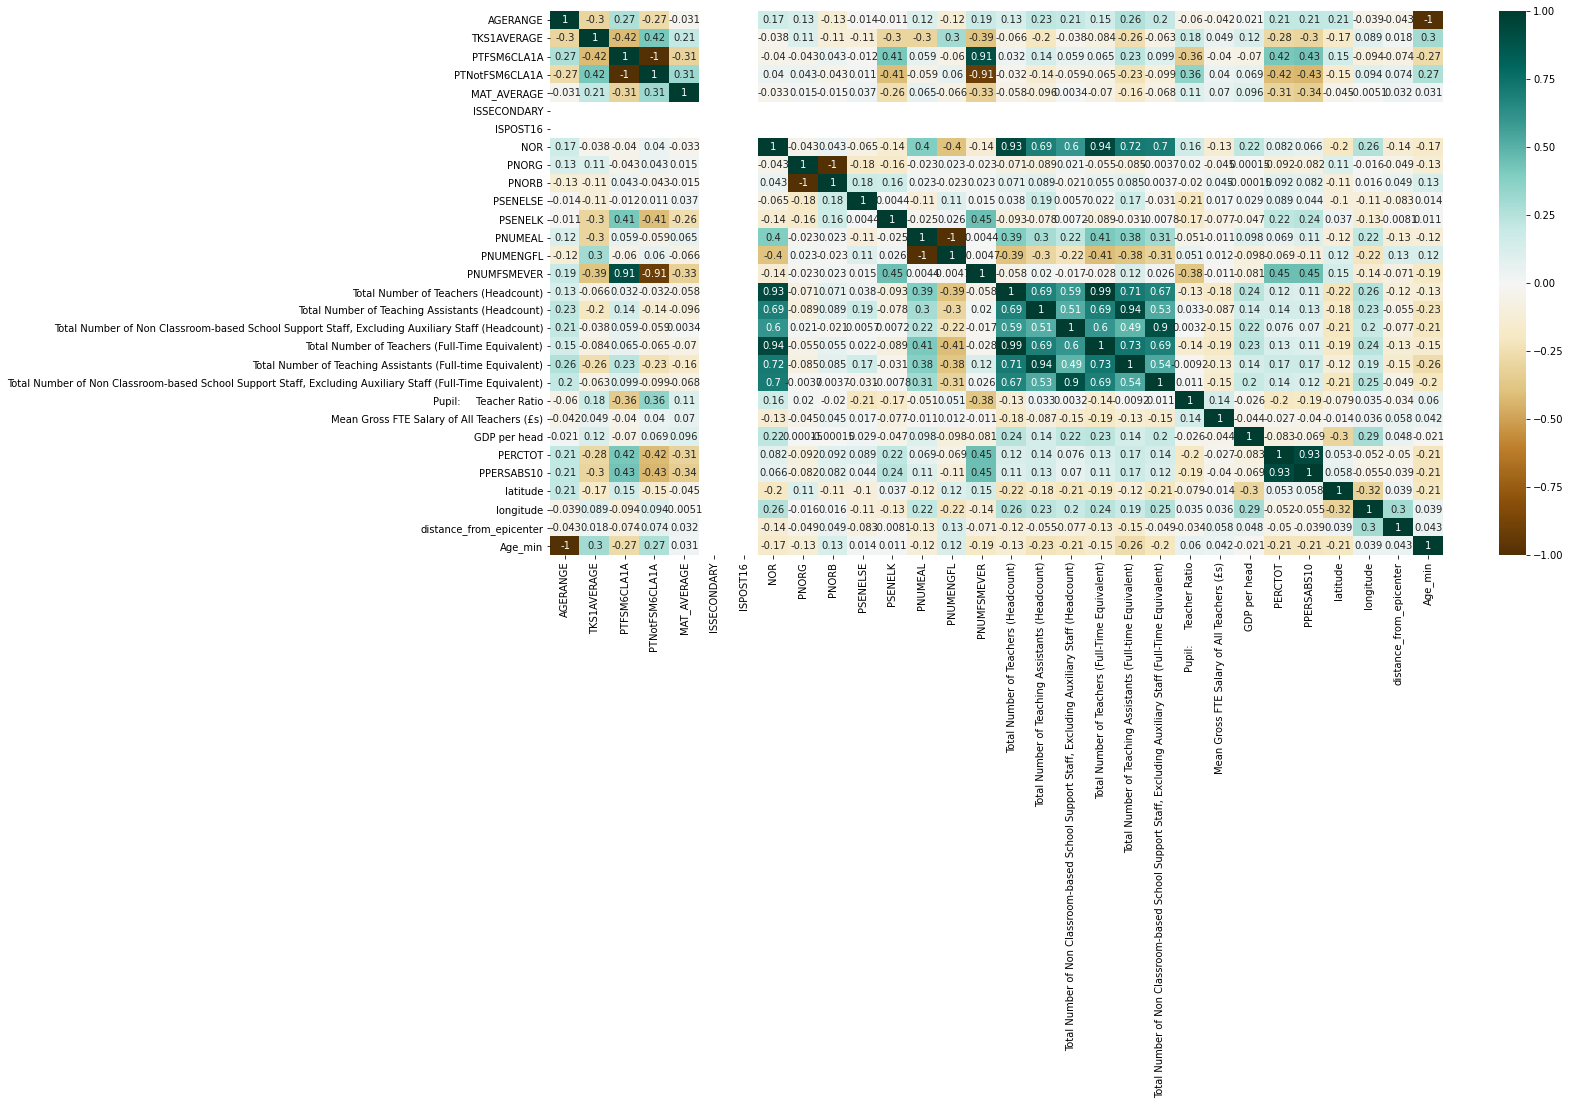

In [219]:
# Exploring the relations in the dataset
plt.figure(figsize=(20,10))
c= df_england.corr()
sns.heatmap(c,cmap='BrBG',annot=True)
c

Heat Maps may be useful when looking to find the dependent variables. Heatmaps are great to visualise the inherent relaltionships embedded in the data. In the above heat an examine that *MAT_AVERAGE*, mainly depends on TKS1AVERAGE, PTNotFSM6CLA1A, PTMAT_EXP as well as the total amount of teachers & assistants and the location. Also, PNUMENGFL and PNUMEAL seem to suffer from multicolinearity. To get an even better idea of the relationship of the features with MAT_AVERAGE and to test for multicolinearity I explore them further.

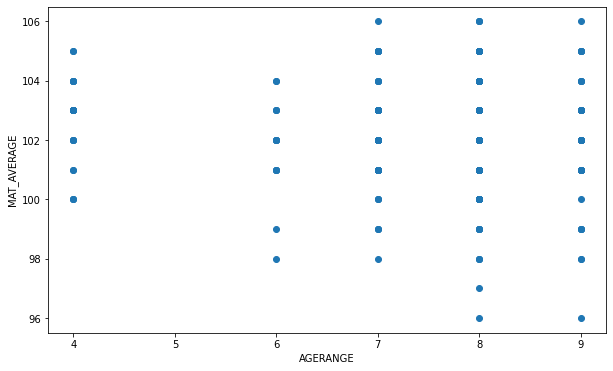

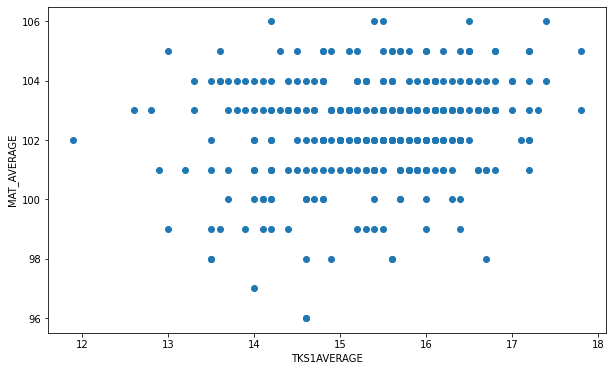

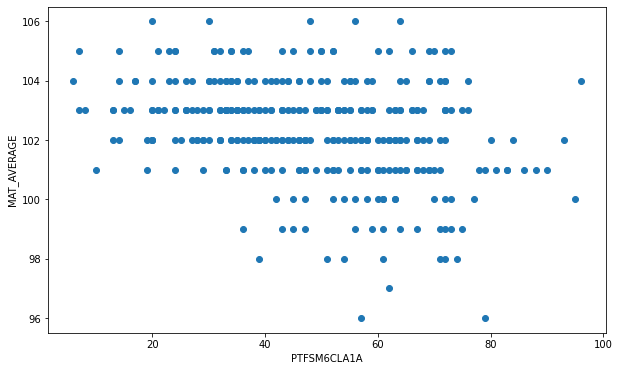

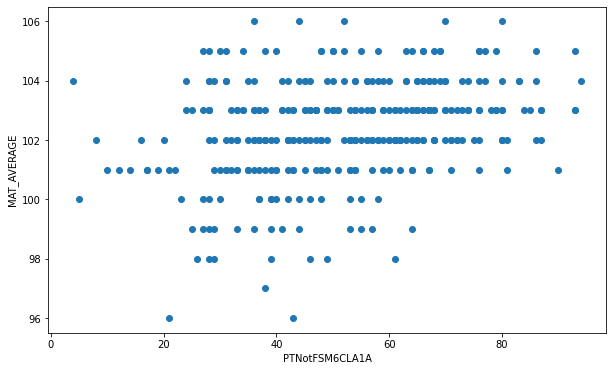

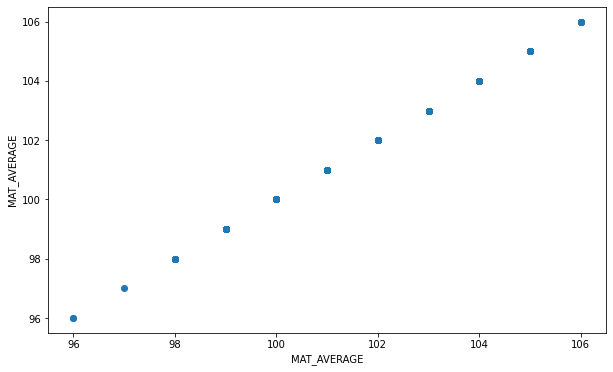

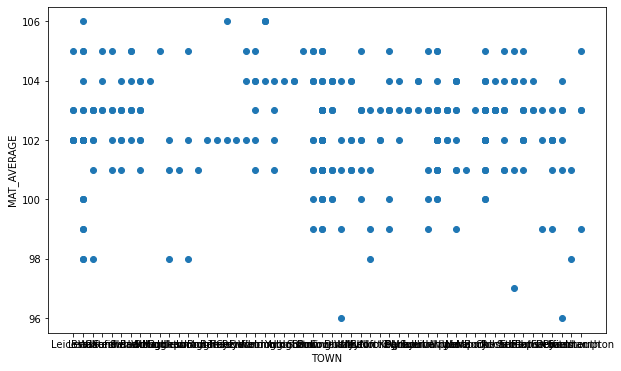

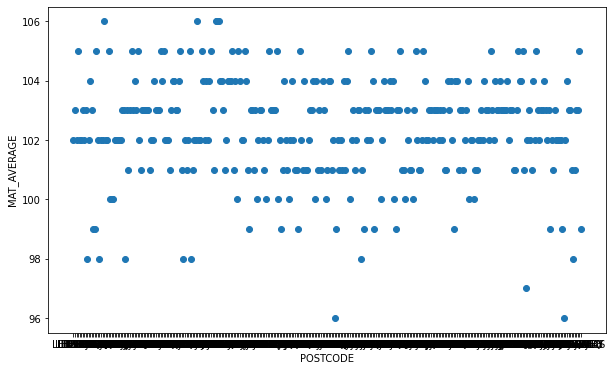

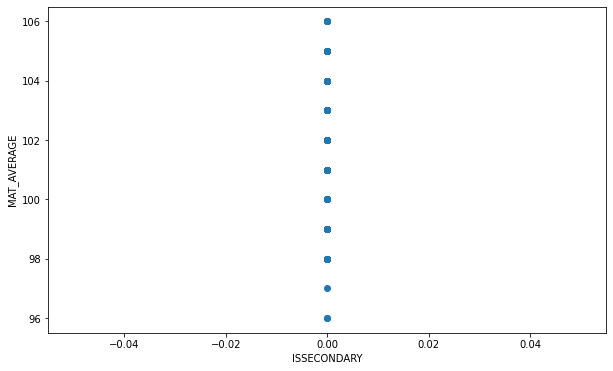

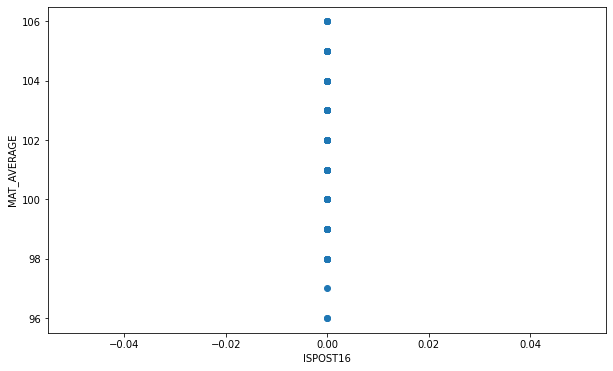

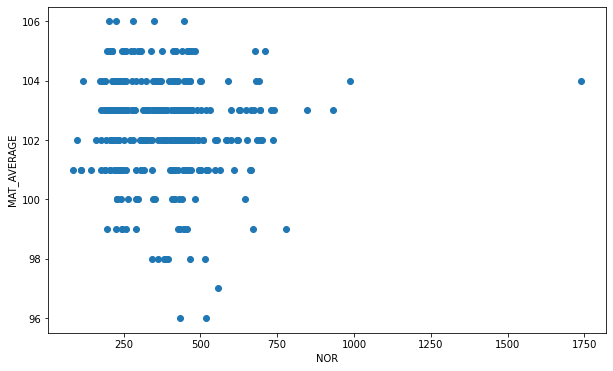

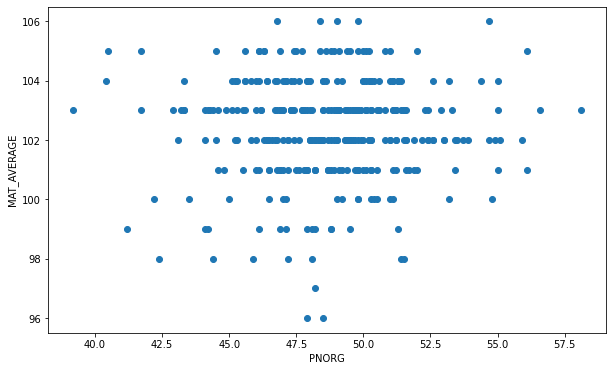

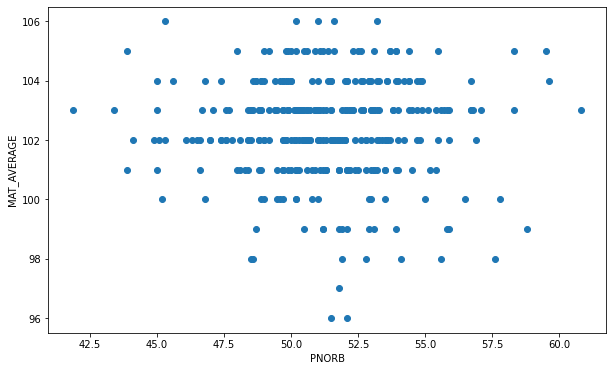

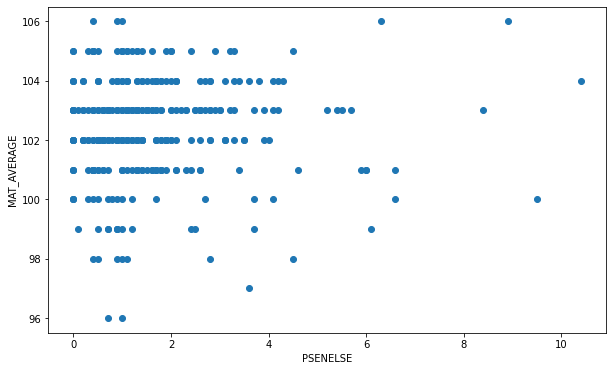

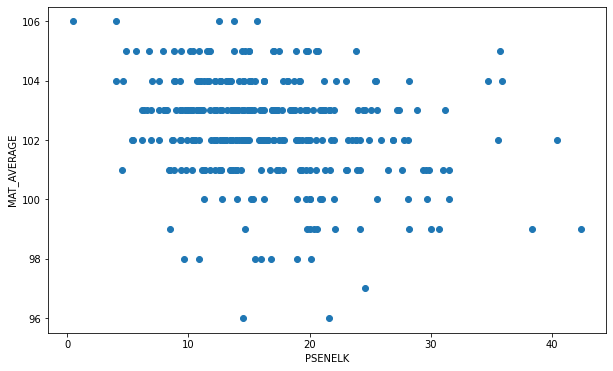

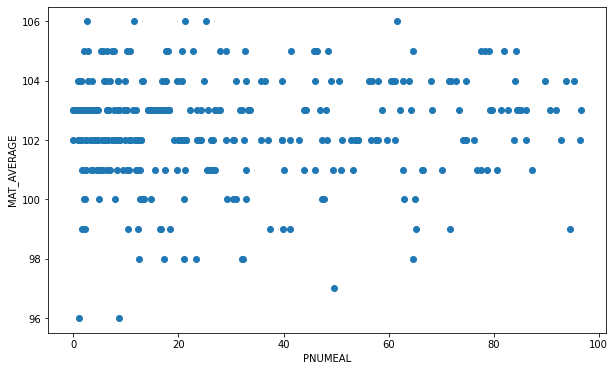

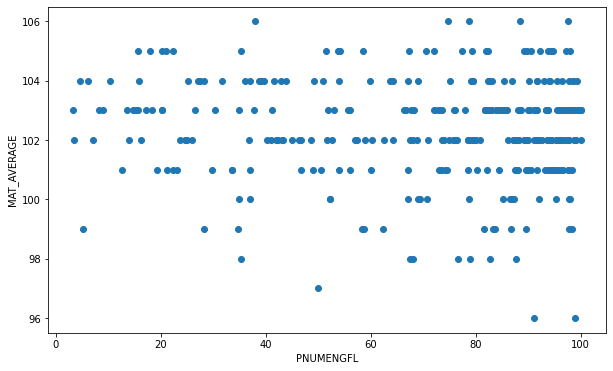

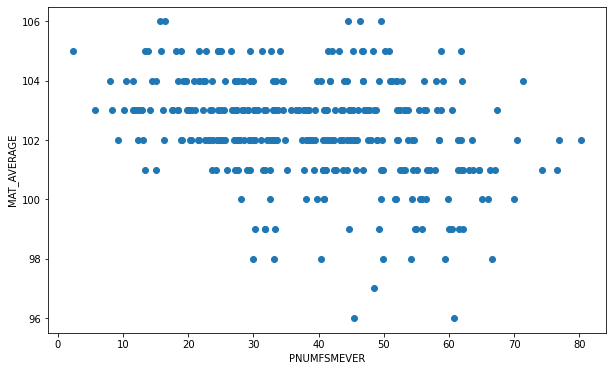

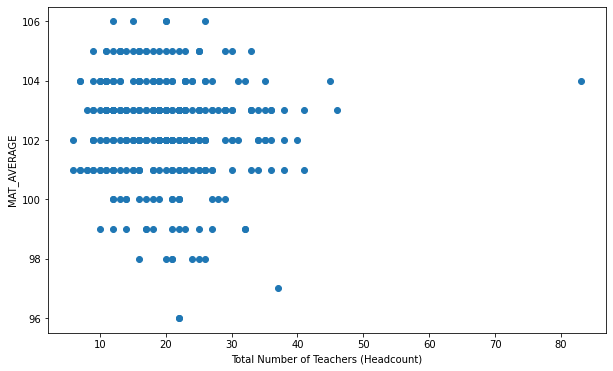

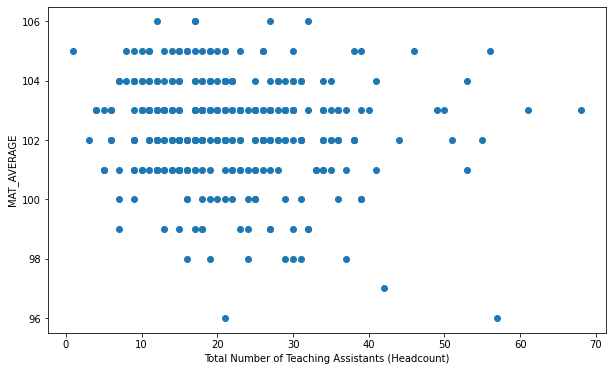

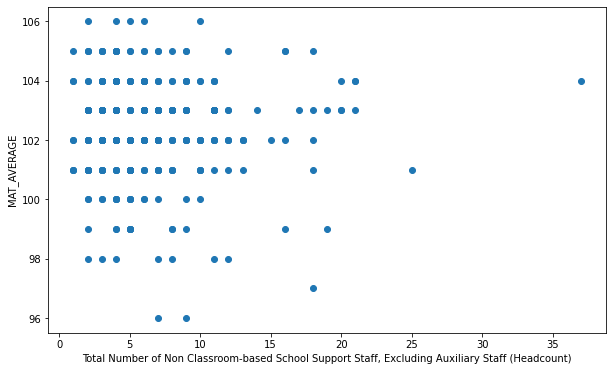

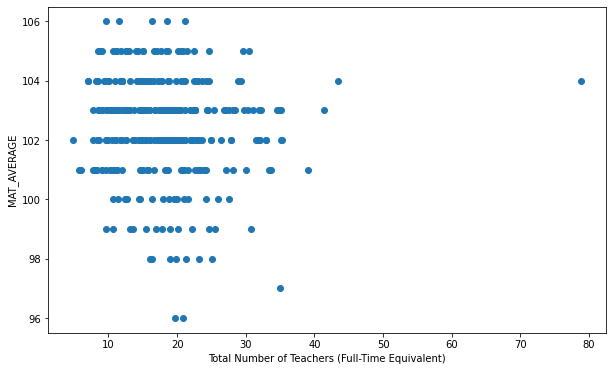

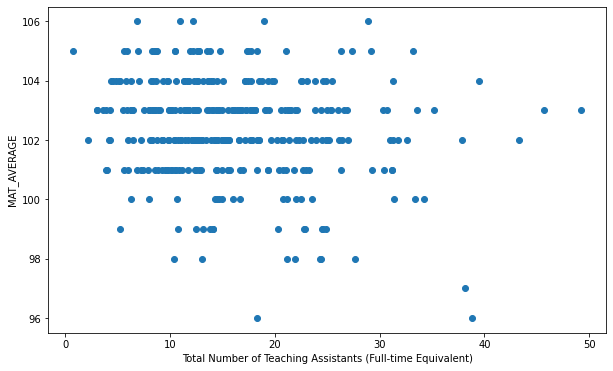

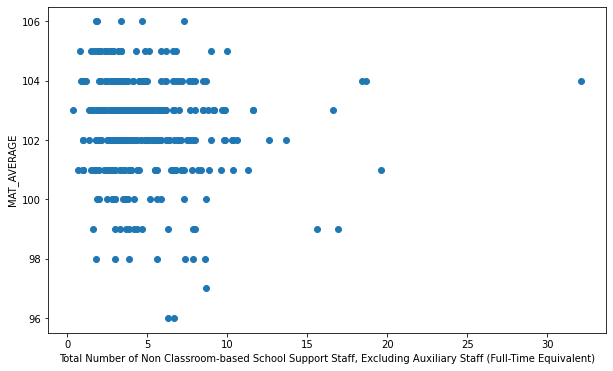

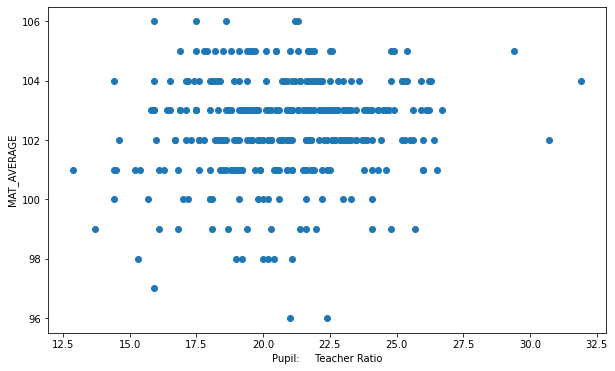

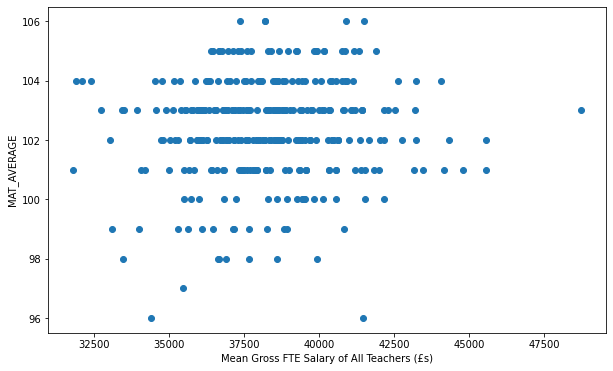

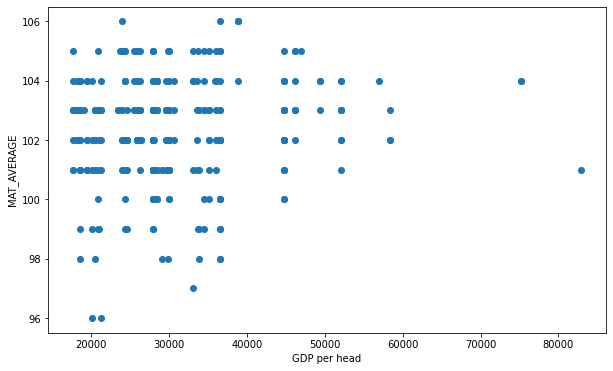

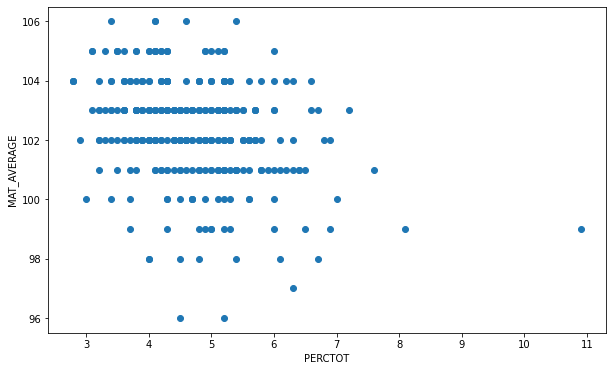

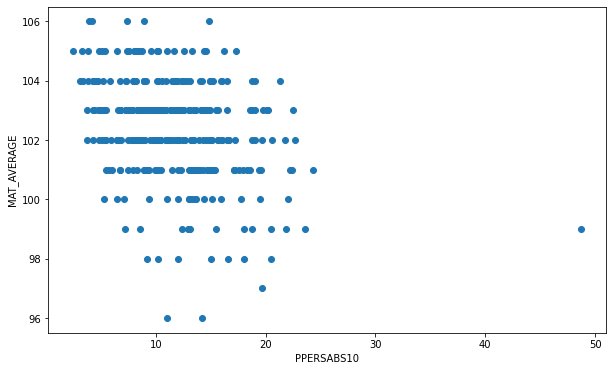

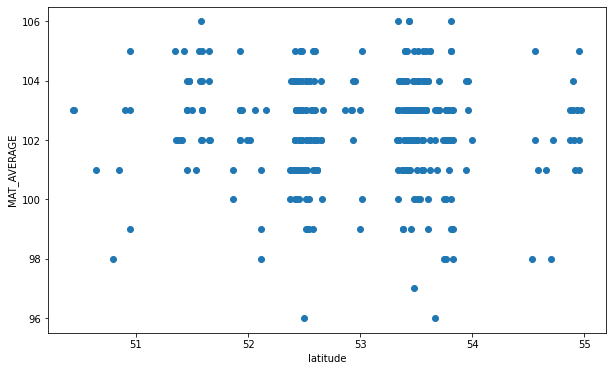

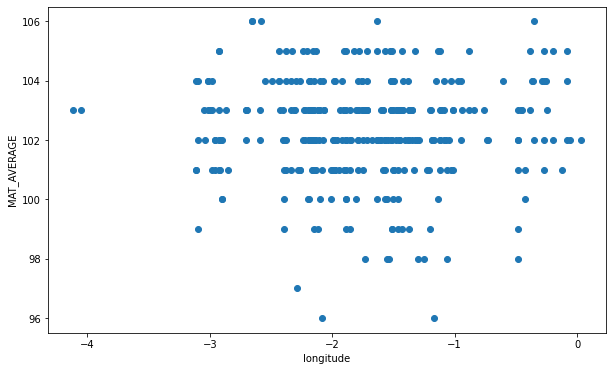

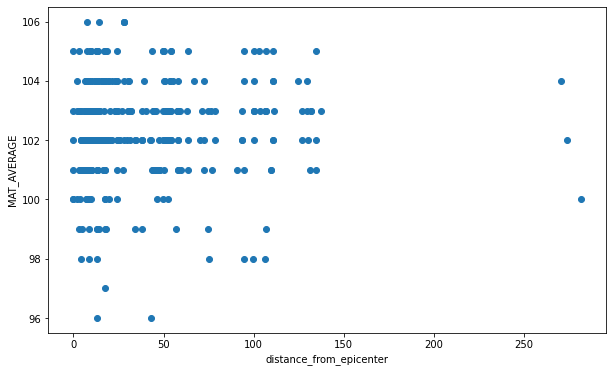

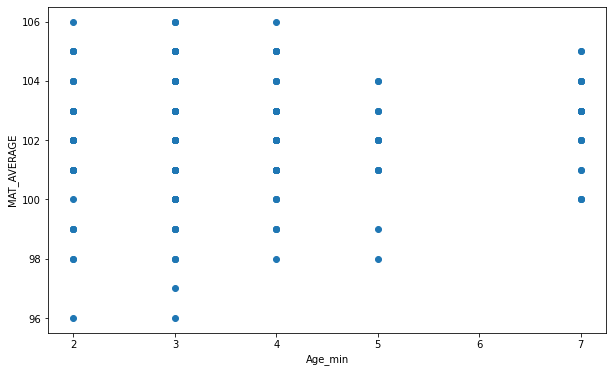

In [220]:
# Plotting a scatter plot to visually check for correlation.
def scatter(x_var):
  """ Generate scatterplot"""
  fig, ax = plt.subplots(figsize=(10,6))
  ax.scatter(df_england[x_var], df_england['MAT_AVERAGE'])
  ax.set_xlabel(x_var)
  ax.set_ylabel('MAT_AVERAGE')
  plt.show()

x_vars = df_england.columns.values.tolist()

for var in x_vars:
  scatter(var)

As suspected before the findings indicate that most variables chosen are not highly correlated with MAT_AVERAGE. Following the mantra of Nassim Taleb (https://nassimtaleb.org/2020/10/fake-regression-psychologists/) I thus refrain from creating so called fake regressions and start infering from the data above.

Visually speaking there seems to be some sort of relationship between the selected variables. Out of curiosity I am also interested in the relationship between the MAT_AVERAGE and the number of teachers. 

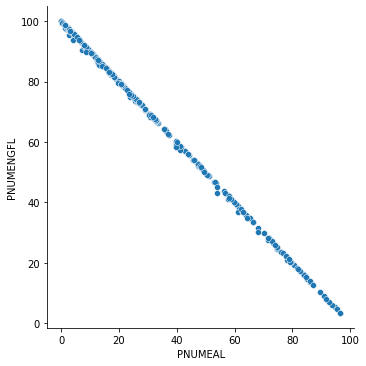

In [221]:
# Testing for multicolinearity
sns.relplot(x="PNUMEAL", y="PNUMENGFL", data=df_england);

Clearily these two features suffer from multicolinearity. Thus I will drop PNUMENGFL.

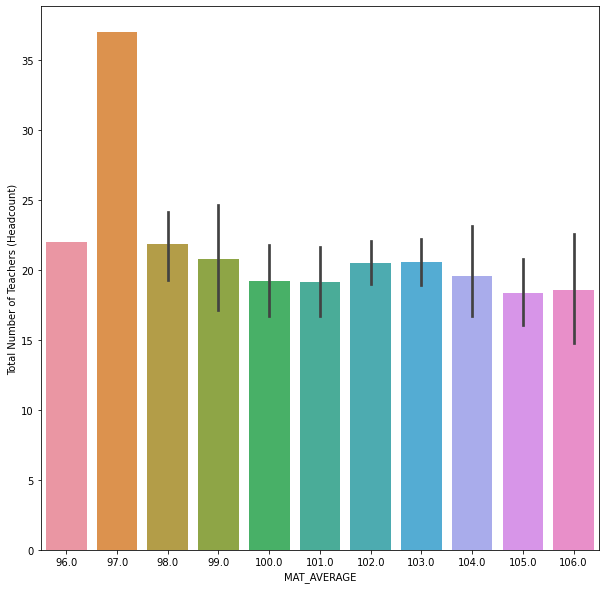

In [222]:
# Check distribution teacher vs. mat_average
fig = plt.figure(figsize = (10,10))
sns.barplot(x = 'MAT_AVERAGE', y = 'Total Number of Teachers (Headcount)', data = df_england)
plt.tick_params(color='black',labelcolor='black')
plt.show()

It appears that higher math scores don't necessarily mean a higher number of teachers.

As it appears the Total Number of Teachers is fairly evenly distributed when considered in relation to MAT_AVERAGE, although there is an outlier at the 97 MAT_AVERAGE.

## Geographical visualisation

To get a better idea of how the schools are geographically distributed we leverage the pgeocode libary to visualise it. I am interested in the distribution of the GDP per head, number of teachers, teacher salary, Pupil teacher ratio and the absence

In [223]:
# Select the columns to be visualised in geographically
df_geo = df_england.filter(['POSTCODE','TOWN','MAT_AVERAGE','GDP per head','Total Number of Teachers (Headcount)','Mean Gross FTE Salary of All Teachers (£s)','Pupil:     Teacher Ratio','distance_from_epicenter','PPERSABS10'], axis=1)

In [224]:
# Lets frist create a test sample using one Postcode from the dataset to extract the long and latitude
nomi = pgeocode.Nominatim('GB')
nomi.query_postal_code("LE5 5LL")

postal_code                           LE5
country_code                           GB
place_name        Humberstone, Stoneygate
state_name                        England
state_code                            ENG
county_name                Leicestershire
county_code                      11609039
community_name                        NaN
community_code                        NaN
latitude                          52.6474
longitude                         -1.0865
accuracy                                4
Name: 0, dtype: object

In [225]:
# Test sample - Extract Latitude
x =nomi.query_postal_code("LE5 5LL")[9]
x = getattr(x, "tolist", lambda: value)()

In [226]:
# To extract all the longitudes and latitudes a loop is created
df_lat =[]
df_long = []
PCODE_list = df_geo['POSTCODE'].tolist()
for i in PCODE_list:
    x = nomi.query_postal_code(i)[9]
    df_lat.append(x)
    y = nomi.query_postal_code(i)[10]
    df_long.append(y)
def long_lat(PCODE_list):
    """ Retreive the longitude and latitude
    per postcode"""
    df_lat =[]
    df_long = []
    for i in PCODE_list:
        x = nomi.query_postal_code(i)[9]
        df_lat.append(x)
        y = nomi.query_postal_code(i)[10]
        df_long.append(y)
    return df_lat, df_long


In [227]:
# Creating additional columns containing the long- and latitudes of the postcodes
df_geo = df_geo.assign(latitude =df_lat)
df_geo = df_geo.assign(longitude =df_long)

In [228]:
# Check the correctness of the dataframe
df_geo.head()

,POSTCODE,TOWN,MAT_AVERAGE,GDP per head,Total Number of Teachers (Headcount),Mean Gross FTE Salary of All Teachers (£s),Pupil: Teacher Ratio,distance_from_epicenter,PPERSABS10,latitude,longitude
8,LE3 2DH,Leicester,102.0,25915.0,24.0,36255,23.9,51.564946,11.9,52.6466,-1.186967
15,LE4 0PT,Leicester,103.0,25915.0,25.0,39742,19.4,57.291057,12.2,52.6667,-1.108733
20,LE2 7JN,Leicester,102.0,25915.0,22.0,36032,19.9,54.212727,10.9,52.5853,-1.116717
22,LE2 6NE,Leicester,105.0,25915.0,25.0,38413,21.0,54.212727,16.2,52.5853,-1.116717
24,LE5 1NG,Leicester,102.0,25915.0,26.0,37396,19.5,57.988428,16.7,52.6474,-1.086500


In [230]:
# Visualise features on a map
def show_vig(value):
  """ Visualise the features on a geographical map"""
  fig = px.scatter_mapbox(df_geo, 
                           lat="latitude", 
                           lon="longitude", 
                           hover_name="TOWN", 
                           zoom=5, 
                           height=300, 
                           color=df_geo[value],
                           size=df_geo["MAT_AVERAGE"],
                           color_continuous_scale=px.colors.cyclical.IceFire,
                           size_max=15)
  fig.update_layout(mapbox_style="open-street-map")
  fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
  fig.show()
    
values = ['GDP per head','Total Number of Teachers (Headcount)','Pupil:     Teacher Ratio','distance_from_epicenter','PPERSABS10']
for value in values:
    show_vig(value)

All the features seem to be fairly evenly distribubted across England (visually speaking). Inly the Pupil and teacher ration seems to suggest some differences in terms of the region, where cities seem to have have higher ratios. As expected the GDP per head is the highest in city centres. Interestingly, the north of England seems to be represented the most overall speaking.

# 5) Predictive Modeling

To predict the average mathematics score of the school I consider OLS, Elastic Net, Random Forest and Neural Networks.

## Model selection

As I am trying to predict the mathematics score for the respective schools (continous variables), the underlying problem constitutes a regression problem. Hence, it is about predicting a continous value similar to predicting the prices of a house given its size, location, number of rooms ecetera. Therefore, the task is more about using regression models instead of classification models. There are a variety of regression models/ algorithms available. 
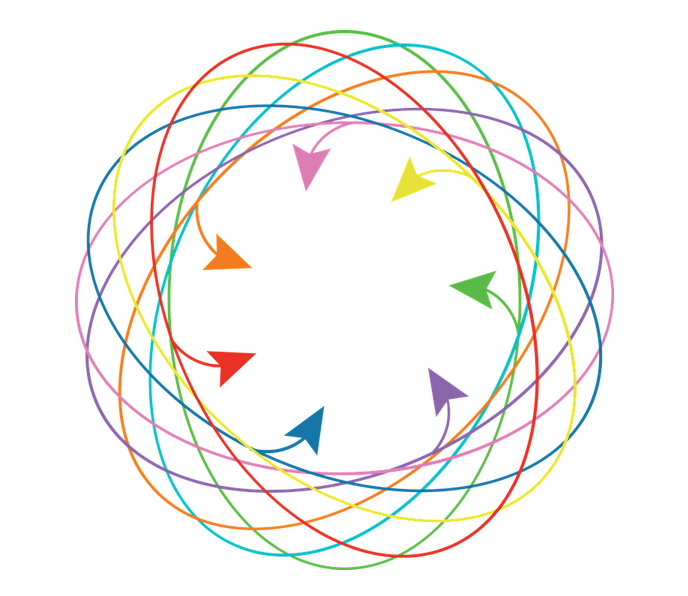

I first choose to go with OLS as it is also able to handle non-linear relationships thus tunring into a multiple linear model. As I assume the data not always to be linear, I additionally consider OLS in relation to robust regression. Robust regression is an alternative to least squares regression when the data may be contaminated with outliers. 

Next, I choose ElasticNet regression/regularisation which combines the L1 and L2 penalties of the lasso and ridge methods. Essentially, this method allows me to overcome the issue as the elastic net performs simultaneous regularization and variable selection (Zhou and Hastie, 2004). Also, the paper *A robust and efficient doubly regularized metric learning approach* uses Elastic Net regularisation on continious features (Liu and Vemuri, 2012). 

Subsequently, I consider Random Forest as it usually holds high accuracy. They are essentially an esemble of decision trees. Also, they account for the decision tree and OLS problem of overfitting their training set (Hand, Mannila and Smyth, 2012). Ramdom Forstes also have the capability of learning complex (non-linear) relationships, which when considering the data may be useful. Nevertheless, their explainability may not always be as easy thus I devote a section to this matter. 

After the Random Forest I turn to Neural Networks. As I observed in the exploratory data analysis, the relationships of the features may be more complex than simple linear regression, thus neural networks may be able to account for this and model the data. Also, considering the future use of the models feeding the neural network with more data may (in the long run) allow it to outperform the other models. Nevertheless, they are quite difficult to interpret and computationally intensive.


### Separation of the data (train test split)

In [83]:
# I first drop the remaining unnecessary columns
df_england = df_england.drop(['TOWN',
                              'ISSECONDARY',
                              'POSTCODE',
                              'ISPOST16',
                              'PNUMENGFL',
                              ],axis=1)
df_england.head()

,AGERANGE,TKS1AVERAGE,PTFSM6CLA1A,PTNotFSM6CLA1A,MAT_AVERAGE,NOR,PNORG,PNORB,PSENELSE,PSENELK,PNUMEAL,PNUMFSMEVER,Total Number of Teachers (Headcount),Total Number of Teaching Assistants (Headcount),"Total Number of Non Classroom-based School Support Staff, Excluding Auxiliary Staff (Headcount)",Total Number of Teachers (Full-Time Equivalent),Total Number of Teaching Assistants (Full-time Equivalent),"Total Number of Non Classroom-based School Support Staff, Excluding Auxiliary Staff (Full-Time Equivalent)",Pupil: Teacher Ratio,Mean Gross FTE Salary of All Teachers (£s),GDP per head,PERCTOT,PPERSABS10,latitude,longitude,distance_from_epicenter,Age_min
8,8,15.7,32,68,102.0,510.0,49.8,50.2,1.2,6.9,52.9,21.5,24.0,31.0,5.0,20.7,20.2,3.2,23.9,36255,25915.0,4.1,11.9,52.6466,-1.186967,51.564946,3
15,8,15.2,53,47,103.0,455.0,43.3,56.7,0.9,17.4,47.0,47.7,25.0,22.0,6.0,22.4,16.4,5.0,19.4,39742,25915.0,5.1,12.2,52.6667,-1.108733,57.291057,3
20,6,16.1,39,61,102.0,384.0,48.2,51.8,0.3,17.7,74.7,25.3,22.0,26.0,7.0,19.3,20.7,5.5,19.9,36032,25915.0,4.5,10.9,52.5853,-1.116717,54.212727,5
22,8,14.9,62,38,105.0,439.0,51.0,49.0,0.9,20.5,41.5,46.7,25.0,26.0,7.0,20.8,21.1,5.1,21.0,38413,25915.0,5.1,16.2,52.5853,-1.116717,54.212727,3
24,8,14.8,52,48,102.0,463.0,48.4,51.6,0.4,13.4,26.3,34.8,26.0,26.0,8.0,22.7,18.5,5.9,19.5,37396,25915.0,5.5,16.7,52.6474,-1.086500,57.988428,3


Now I split the data into a training and test set. I assign an integer value to the random_state parameter in the train_test_split function to ensure I get the same split every time in the data.

In [84]:
# Grouping the data into dependent and indepent variables (y-variable is dependent, x-variables are independent)
X=df_england.drop(['MAT_AVERAGE'],axis=1)
y=df_england['MAT_AVERAGE']

# build a training dataset with 70% data and a testing dataset with 30% data
# Random_state is used to enable repeatability
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=30)

In [85]:
#Statistical test
import statsmodels.tsa.stattools as sm

result = sm.adfuller(y_train)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -15.273156
p-value: 0.000000


The results indicate that the indepent variable is stationary, which is good news. Now let's see how an OLS regression performs versus a robust linear model (RLM), which can handle outliers and in some setups, heteroskadisticity:

### Feature scaling & Feature selection

The Shapiro-Wilk test evaluates a data sample and quantifies how likely it is that the data was drawn from a Gaussian distribution, named for Samuel Shapiro and Martin Wilk.
I test out H0, that the data is normally distributed.

In [86]:
# normality test
stat, p = shapiro(df_england)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')
print(p)

Statistics=0.299, p=0.000
Sample does not look Gaussian (reject H0)
0.0


/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning:

p-value may not be accurate for N > 5000.



From the output I can see that the test statistic is 0.0.286 and the corresponding p-value is 0.000. Since the p-value is less than .05, I reject the null hypothesis. I have sufficient evidence to say that the sample data does not come from a normal distribution.
As the H0 is rejected (H0 = data is Gaussian) I thus use normalisation, as pointed out by (Bhandri, 2020)



In [87]:
# Scale the train values
x = X_train.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
X_train_scaled = min_max_scaler.fit_transform(x)
X_train = pd.DataFrame(X_train_scaled,columns = X_train.columns,index=X_train.index)

# Scale the test values
x = X_test.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
X_test_scaled = min_max_scaler.fit_transform(x)
X_test = pd.DataFrame(X_test_scaled,columns = X_test.columns,index=X_test.index)

In [88]:
# Check if dataframe was converted correctly
X_test

,AGERANGE,TKS1AVERAGE,PTFSM6CLA1A,PTNotFSM6CLA1A,NOR,PNORG,PNORB,PSENELSE,PSENELK,PNUMEAL,PNUMFSMEVER,Total Number of Teachers (Headcount),Total Number of Teaching Assistants (Headcount),"Total Number of Non Classroom-based School Support Staff, Excluding Auxiliary Staff (Headcount)",Total Number of Teachers (Full-Time Equivalent),Total Number of Teaching Assistants (Full-time Equivalent),"Total Number of Non Classroom-based School Support Staff, Excluding Auxiliary Staff (Full-Time Equivalent)",Pupil: Teacher Ratio,Mean Gross FTE Salary of All Teachers (£s),GDP per head,PERCTOT,PPERSABS10,latitude,longitude,distance_from_epicenter,Age_min
189,0.0,0.762712,0.0875,0.911392,0.148936,0.710059,0.289941,0.134615,0.507813,0.092228,0.153738,0.200,0.183333,0.083333,0.153425,0.150826,0.069149,0.414013,0.294787,0.528118,0.326923,0.407583,0.204276,0.755847,0.226745,1.0
383,0.8,0.423729,0.4875,0.506329,0.191489,0.603550,0.396450,0.576923,0.114583,0.204145,0.423131,0.175,0.350000,0.083333,0.172603,0.328512,0.117021,0.458599,0.407600,0.101437,0.557692,0.587678,0.696455,0.427412,0.225643,0.2
519,0.8,0.694915,0.3000,0.696203,0.724586,0.633136,0.366864,0.182692,0.164062,0.009326,0.222849,0.500,0.500000,0.416667,0.550685,0.469008,0.356383,0.808917,0.623262,0.036759,0.538462,0.668246,0.465424,0.487187,0.057828,0.2
328,0.6,0.728814,0.0000,1.000000,0.011820,0.792899,0.207101,0.000000,0.138021,0.000000,0.000000,0.000,0.033333,0.000000,0.000000,0.028926,0.010638,0.388535,0.423440,0.243561,0.000000,0.056872,0.796486,0.762177,0.177751,0.4
304,0.8,0.610169,0.5375,0.455696,0.308511,0.449704,0.550296,0.605769,0.000000,0.220725,0.496474,0.350,0.516667,0.041667,0.372603,0.580579,0.053191,0.242038,0.452294,0.324662,0.230769,0.232227,0.670304,0.361891,0.100159,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574,0.4,0.508475,0.4750,0.518987,0.326241,0.307692,0.692308,0.105769,0.390625,0.333679,0.291961,0.375,0.300000,0.250000,0.312329,0.198347,0.255319,0.471338,0.357254,0.247705,0.211538,0.317536,0.375118,0.902006,0.266872,0.6
511,1.0,0.542373,0.6250,0.367089,0.417258,0.721893,0.278107,0.067308,0.216146,0.454922,0.622003,0.525,0.433333,0.166667,0.534247,0.425620,0.175532,0.203822,0.408493,0.165132,0.307692,0.379147,0.444472,0.658884,0.044751,0.0
227,0.8,0.542373,0.9375,0.050633,0.066194,0.656805,0.343195,0.134615,0.151042,0.050777,0.733427,0.075,0.200000,0.000000,0.112329,0.194215,0.010638,0.095541,0.433628,0.013092,0.480769,0.748815,0.945458,0.720042,0.389599,0.2
54,0.8,0.237288,0.4750,0.518987,0.761229,0.644970,0.355030,0.028846,0.283854,0.874611,0.320169,0.750,0.633333,0.416667,0.813699,0.609504,0.446809,0.382166,0.254257,0.288256,0.442308,0.502370,0.757966,0.646292,0.049838,0.2


## Ordinary least squares regression (OLS)

In OLS the goal is for the model to fit the data perfectly. In other words I want to find $\mathbf{w}$ such that

$$
    \mathbf{y} = \mathbf{\bar{X}} \mathbf{w}.
$$

With a little matrix algebra I get

$$
\begin{align}
    \mathbf{y} & = \mathbf{\bar{X}} \mathbf{w}, \\
    \mathbf{\bar{X}}^T \mathbf{y} & = (\mathbf{\bar{X}}^T \mathbf{\bar{X}}) \mathbf{w}, \\
    ( \mathbf{\bar{X}}^T \mathbf{\bar{X}} )^{-1} \mathbf{\bar{X}}^T \mathbf{\hat{y}} & = ( \mathbf{\bar{X}}^T \mathbf{\bar{X}} )^{-1} (\mathbf{\bar{X}}^T \mathbf{\bar{X}}) \mathbf{w}, \\
    ( \mathbf{\bar{X}}^T \mathbf{\bar{X}} )^{-1} \mathbf{\bar{X}}^T \mathbf{\hat{y}} & = \mathbf{w}.
\end{align}
$$

Here I have found an algebraic solution for $\mathbf{w}$. This is by no means the whole story but it is enough to demonstrate the OLS is not an iterative method.

In [90]:
#Examine in sample model outputs
import statsmodels.api as sm

#OLS model - risks violating heteroskadasticity assumptions though
ols_model = OLS(y_train,X_train)
res = ols_model.fit()
print(res.summary())

#robust linear model covers this base
rlm_model = sm.RLM(y_train, X_train, M=sm.robust.norms.HuberT())
rlm_res = rlm_model.fit()
y_hat = rlm_res.predict(X_train)
rlm_res.summary()

                            OLS Regression Results                            
Dep. Variable:            MAT_AVERAGE   R-squared:                       0.334
Model:                            OLS   Adj. R-squared:                  0.253
Method:                 Least Squares   F-statistic:                     4.140
Date:                Mon, 29 Mar 2021   Prob (F-statistic):           1.03e-08
Time:                        12:41:54   Log-Likelihood:                -383.55
No. Observations:                 223   AIC:                             817.1
Df Residuals:                     198   BIC:                             902.3
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                                                                                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:            MAT_AVERAGE   No. Observations:                  223
Model:                            RLM   Df Residuals:                      198
Method:                          IRLS   Df Model:                           24
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 29 Mar 2021                                         
Time:                        12:41:54                                         
No. Iterations:                    24                                         
==============================================================================================================================================================================
                                                                                                                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
AGERANGE                                                                                                      -5.3295     44.181     -0.121      0.904     -91.924      81.265
TKS1AVERAGE                                                                                                    0.3555      0.583      0.610      0.542      -0.788       1.499
PTFSM6CLA1A                                                                                                  114.7580     88.319      1.299      0.194     -58.345     287.861
PTNotFSM6CLA1A                                                                                               114.8880     88.262      1.302      0.193     -58.101     287.877
NOR                                                                                                           10.2274      6.455      1.584      0.113      -2.425      22.880
PNORG                                                                                                         -5.8412     44.161     -0.132      0.895     -92.395      80.713
PNORB                                                                                                         -5.1685     44.176     -0.117      0.907     -91.753      81.416
PSENELSE                                                                                                       2.0561      0.717      2.866      0.004       0.650       3.462
PSENELK                                                                                                       -1.2526      0.611     -2.050      0.040      -2.450      -0.055
PNUMEAL                                                                                                        1.7001      0.398      4.274      0.000       0.920       2.480
PNUMFSMEVER                                                                                                   -0.6242      1.101     -0.567      0.571      -2.782       1.534
Total Number of Teachers (Headcount)                                                                           3.4231      5.624      0.609      0.543      -7.601      14.447
Total Number of Teaching Assistants (Headcount)                                                                0.8870      1.870      0.474      0.635      -2.779       4.553
Total Number of Non Classroom-based School Support Staff, Excluding Auxiliary Staff (Headcount)                4.5200      1.755      2.575      0.010       1.079       7.961
Total Number of Teachers (Full-Time Equivalent)                                                             

Some independent variables register as less important in the RLM than in the OLS model, demonstrating the impact of heteroskedastcity on a naive interpretation.

Eyeballing the residuals is a good way to determine any violations or biases in the training data. I expect to see more or less  𝑖𝑖𝑑  residuals. I cant expect this to be perfect but material skews in the distribution would represent a major problem with the model:

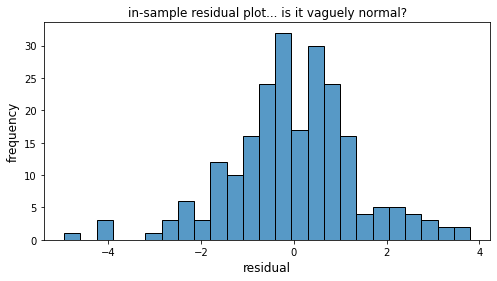

In [91]:
#Sense check residuals
e_train = y_train - y_hat

fig, ax = plt.subplots(1, 1, figsize=(8,4))
sns.histplot(data=e_train,bins=25, ax=ax)

# Add labels
ax.set_title('in-sample residual plot... is it vaguely normal?', fontsize=12)
ax.set_xlabel('residual', fontsize=12)
ax.set_ylabel('frequency', fontsize=12);

The residulas seem to be vaguely normal although one may attest it a left skewedness.

### Linear Models: Conclusions

- The Linear model does a reasonable job modelling the data in general. 
- However, it is the case that the more independent variables I throw at a linear regression model the greater the explanatory power will be, and the higher the error is likely to be out of sample. This issue is known as overfit or variance and is addressed by fudges like ***adjusted $R^\mathbf{2}$***. 

This poses key questions for how I construct models:

1) How to select the most powerful indepdent variables? 
2) How to combine these?

This brings me onto the topic of regularisation, or exerting a cost for having non-zero model weights.

## Elastic net

Elastic nets combine L1 and L2 regularisation. 
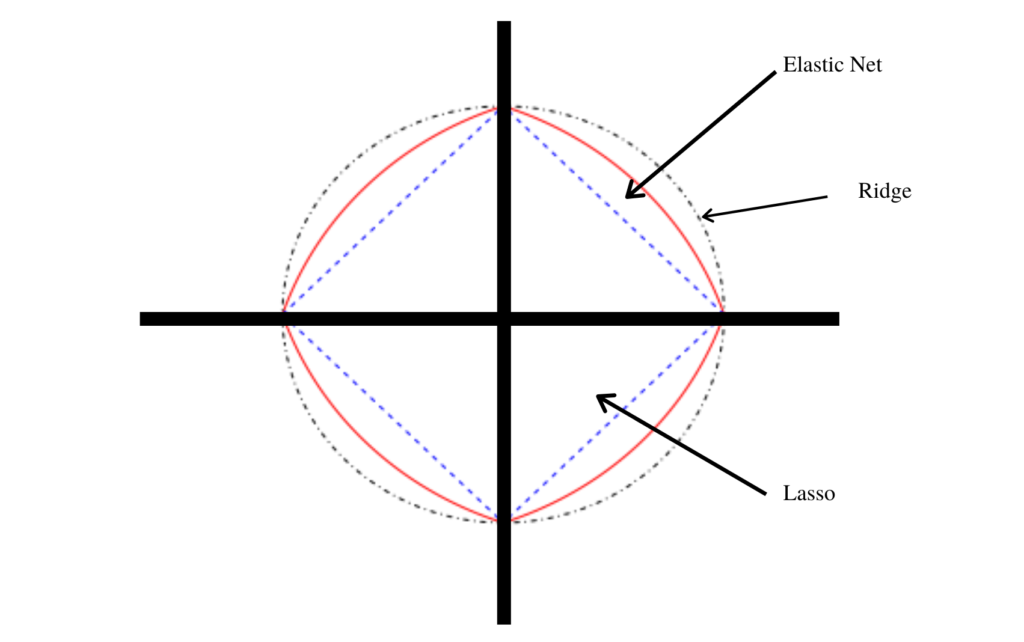


The fitting process uses gradient descent to iteratively adjust the value of the model parameters to reduce a loss function. Elastic nets include both the lasso and ridge regression terms.
* Regularisation penalises a model for having non-zero parameters
* ...and therefore provides a trade off between the reduction in error an increased model complexity
* L1 and L2 are the most common forms of regularisation, improving generalisation of models by reducing overfit. 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 184.6366357304072, tolerance: 0.061144394618834114

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.99860788836827, tolerance: 0.061144394618834114

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0767002281129976, tolerance: 0.061144394618834114

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4272706548405836, tolerance: 

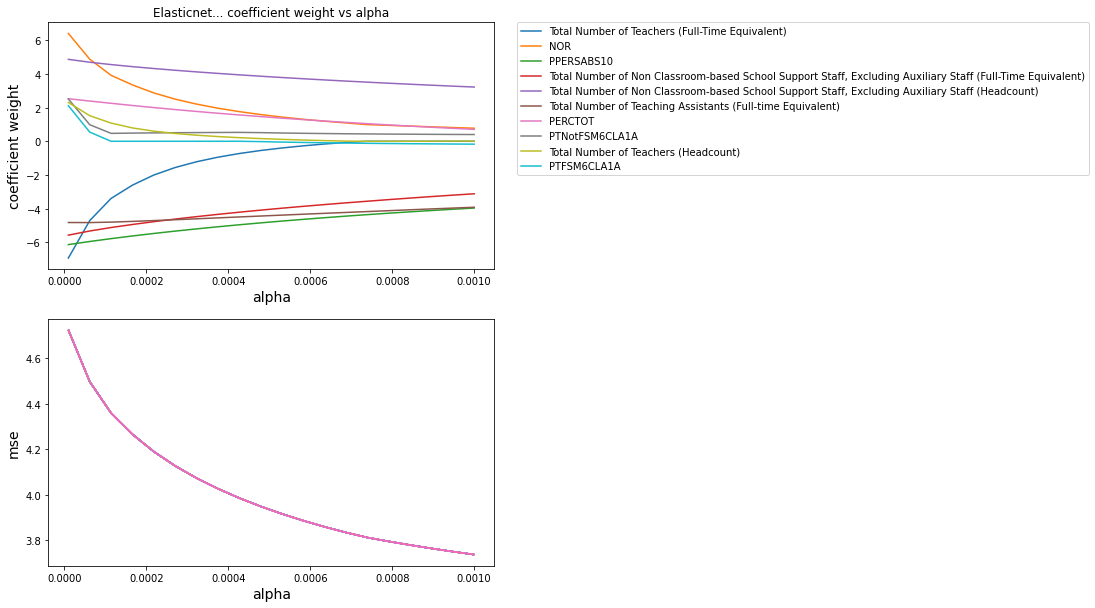

In [92]:
# Build elastic net model
n = 20
alphas = np.linspace(0.00001,0.001, n) # generate n equally space points between 0.00001, and 0.001

coefficients = pd.DataFrame(index=X.columns) 
mse = pd.DataFrame(columns=X.columns)

for alpha in alphas:
    EN = ElasticNet(alpha=alpha)
    EN.fit(X_train, y_train)
    y_hat = EN.predict(X_test)
    
    # add a column alpha containing the weights of the coefficients of the model
    coefficients[alpha] = EN.coef_
    
    #save the MSE for this value of alpha....
    mse.loc[alpha] = mean_squared_error(y_hat, y_test)

# select the rows with the 10 largest absolutes value for the first value of alpha
coefficients = coefficients.loc[
    coefficients.abs().nlargest(10, coefficients.columns[0]).index, :
]

#Plot the relationship between alpha and coefficient weight
fig, ax = plt.subplots(2, 1, figsize=(8,10))
sns.lineplot(data=coefficients.T, dashes=False, ax=ax[0])
ax[0].set_title('Elasticnet... coefficient weight vs alpha')
ax[0].legend(bbox_to_anchor=(1.05, 1.), loc=2, borderaxespad=0.) # place the legend outside of the plot
ax[0].set_xlabel("alpha", fontsize=14)
ax[0].set_ylabel("coefficient weight", fontsize=14);

# alpha and mse
sns.lineplot(data=mse, ax=ax[1])
ax[1].get_legend().remove()
ax[1].set_xlabel("alpha", fontsize=14)
ax[1].set_ylabel("mse", fontsize=14);

- In the above plot, I see that as $\alpha$ is increased the coefficients don't necessary change a lot. 

Now let's look at how the ```l1_ratio``` affects the coefficients of the model. 

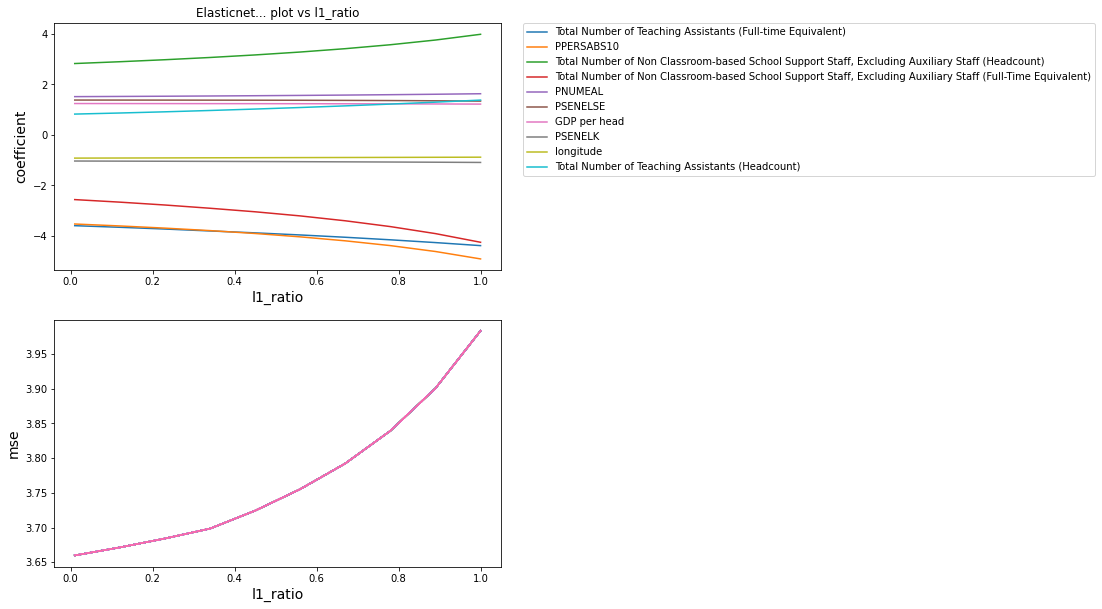

In [93]:
# Elastic net and L1 ratio
n = 10
l1_ratios = np.linspace(0.01, 1, n) # I did not include 0 since the model didn't converge in this case

coefficients = pd.DataFrame(index=X.columns)
mse = pd.DataFrame(columns=X.columns)
for l1_ratio in l1_ratios:
    EN = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
    EN.fit(X_train, y_train)     
    y_hat = EN.predict(X_test)
    
    # add a row indexed alpha containing the coefficients of the model
    coefficients[l1_ratio] = EN.coef_    
     
    #save the MSE of this value of alpha....
    mse.loc[l1_ratio] = mean_squared_error(y_hat, y_test)  
    
# select the rows with the 10 largest absolutes value for the first value of alpha
coefficients = coefficients.loc[
    coefficients.abs().nlargest(10, coefficients.columns[0]).index, :
]

fig, ax = plt.subplots(2, 1, figsize=(8,10))
sns.lineplot(data=coefficients.T, dashes=False, ax=ax[0])
ax[0].set_title('Elasticnet... plot vs l1_ratio')
ax[0].legend(bbox_to_anchor=(1.05, 1.), loc=2, borderaxespad=0.) # place the legend outside of the plot
ax[0].set_xlabel("l1_ratio", fontsize=14)
ax[0].set_ylabel("coefficient", fontsize=14);

#... alpha and mse
sns.lineplot(data=mse, dashes=False, ax=ax[1])
ax[1].get_legend().remove()
ax[1].set_xlabel("l1_ratio", fontsize=14)
ax[1].set_ylabel("mse", fontsize=14);



*   As the l1 ratio increases the mse does so too. From the graph one might infer an almost linear relationship between the two.


### Hyperparameter tuning

Now that I have seen how alpha and the l1_ratio affect the coefficients in the model, I try to pick a good combination of hyperparameters to fit the data. To do this I will use grid search cross validation. This allows me to define a space of hyperparameters to try, evaluate the performance of the model with each combination of hyperparameters, and pick the best hyperparameters that fit the test set the best.

Hyperparameter search results. Alpha: 0.01 ; L1_ratio= 0.9


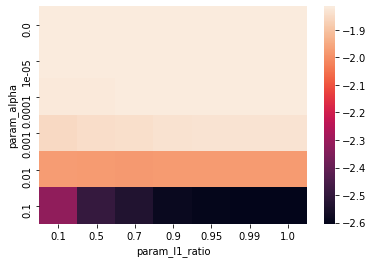

In [94]:
# **************************************
# **************************************
# LONG PROCESSING TIME!!
# **************************************
# **************************************

model = ElasticNet()

# Define the search I want to do on alpha and l1_ratio...
grid = {
    "alpha" : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0],
    'l1_ratio' : [.1, .5, .7, .9, .95, .99, 1]
}

# the cross validation I want to tune on...
cv = RepeatedKFold(
    n_splits=10, # number of subsets that the data is split into
    n_repeats=5  # number of times the data is randomly split into subsets
)

# Grid search... note that I pass an ElasticNet() function handle in, to then grid search alpha and l1_ratio, minimising the neg_mean_squared_error...
search = GridSearchCV(model, grid, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, return_train_score=True)
res = search.fit(X_train, y_train)


# Plot the results from the grid search as a heat map
results = pd.DataFrame(search.cv_results_,
    columns=['param_alpha', 'param_l1_ratio', 'mean_train_score']
)
results = results.pivot(index='param_alpha', columns='param_l1_ratio', values='mean_train_score')
sns.heatmap(results);

print('Hyperparameter search results. Alpha:', search.best_estimator_.alpha, '; L1_ratio=', search.best_estimator_.l1_ratio)

In [95]:
mse = ((res.predict(X_test) - y_test) ** 2).mean() # mean squared error
print("MSE: ", mse)

MSE:  3.3563851713576227


The achieved MSE of 3.35 of the Elastic Net is somewhat decent. Lets have a look at other algorithms and see how they fare.

## Random forest

In this section, I will look at fitting a random forest to the data.
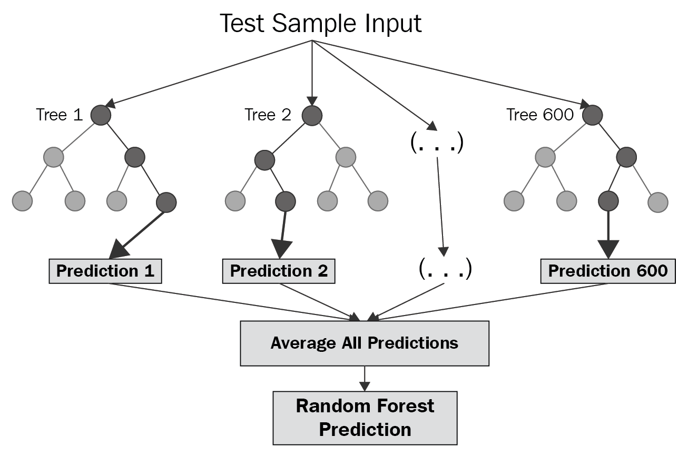

A random forest is an ensemble method that fits a number of decision trees to the data and makes an overall prediction based on the predictions of the individual decision trees. 

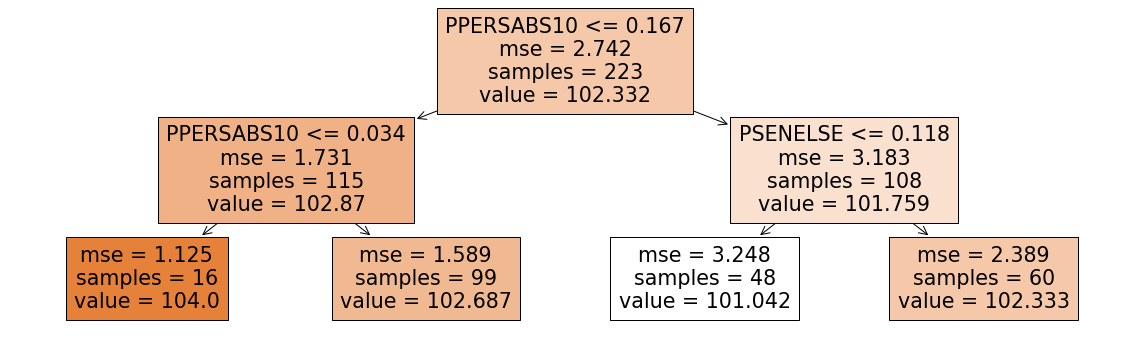

In [96]:
# Lets create an arbitrary RandomForestRegressor
rf = RandomForestRegressor(
    n_estimators = 1,  # limit the model to only 1 decision tree
    criterion = 'mse',
    max_depth = 2,     # limit the depth of the decision tree to 2
    bootstrap=False    # this ensure the decision tree uses the entire dataset
)

rf.fit(X_train, y_train)
trees = rf.estimators_ # a list of the decision trees

# plot the decision tree
fig, ax = plt.subplots(1, 1, figsize=(20,6))
tree.plot_tree(
    trees[0],
    feature_names = X.columns, # labels the feature that each node is making a decision on
    filled = True,
    ax=ax
);

The above illustrated RandomForestRegressor may be interpreted as follows:


*   IF PPERSABS10 is smaller or equal to 0.167 move to left, else move to right
*   If left, IF PPERSABS10 is smaller or equal to 0.034, get MSE
* If right, IF PPERSABS10 is smaller or equal to 0.118, get MSE



### Hyperparameter tuning

In [97]:
# Look at parameters used by the current forest
print('Parameters currently in use:\n')
print(rf.get_params())

Parameters currently in use:

{'bootstrap': False, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 2, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 1, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


I will try adjusting the following set of hyperparameters:
* n_estimators = number of trees in the foreset
*   max_features = max number of features considered for splitting a node
*   max_depth = max number of levels in each decision tree
*min_samples_split = min number of data points placed in a node before the node is split
*min_samples_leaf = min number of data points allowed in a leaf node
*bootstrap = method for sampling data points (with or without replacement)

In [98]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


Now, I instantiate the random search and fit it like any Scikit-Learn model:

In [99]:
# **************************************
# **************************************
# SUPER LONG PROCESSING TIME!!
# **************************************
# **************************************

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  8.5min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

Let's view the best parameters from fitting the random search:

In [100]:
# Get the best parameters
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 90,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 800}

From these results, I should be able to narrow the range of values for each hyperparameter.

To determine if random search yielded a better model, I compare the base model with the best random search model.

In [101]:
# Check for improvements
def evaluate(model, test_features, test_labels):
    """ Evaluate model improvement and performance"""
    predictions = model.predict(X_test)
    errors = abs(predictions - y_test)
    mape = 100 * np.mean(errors / y_test)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance
Average Error: 1.5664 degrees.
Accuracy = 98.47%.
Model Performance
Average Error: 1.4623 degrees.
Accuracy = 98.57%.
Improvement of 0.10%.


The achieved improvement of 0.10% is negligable. Although, depending on the application this may be a lot. 

Let's further improve the results by using grid search to focus on the most promising hyperparameters ranges found in the random search.

In [102]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [5,10,15,20,25],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [1, 2, 3],
    'n_estimators': [350, 400, 450, 500]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [103]:
# **************************************
# **************************************
# SUPER LONG PROCESSING TIME!!
# **************************************
# **************************************

# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Fitting 3 folds for each of 360 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:  8.5min finished


Model Performance
Average Error: 1.4629 degrees.
Accuracy = 98.57%.
Improvement of 0.10%.


The achieved improvement is again negligable with 0.10%

In [104]:
# **************************************
# **************************************
# SUPER LONG PROCESSING TIME!!
# **************************************
# **************************************

best_grid.fit(X_train, y_train)
mse_test = mean_squared_error(y_test, best_grid.predict(X_test))
mse_train = mean_squared_error(y_train, best_grid.predict(X_train))

print("MSE test: ", mse_test)
print("MSE train: ", mse_train)

MSE test:  3.29421817815451
MSE train:  1.1203778623607843


The results indicate a somewhat acceptable performance of the model. Next, I look to visualise the trees.

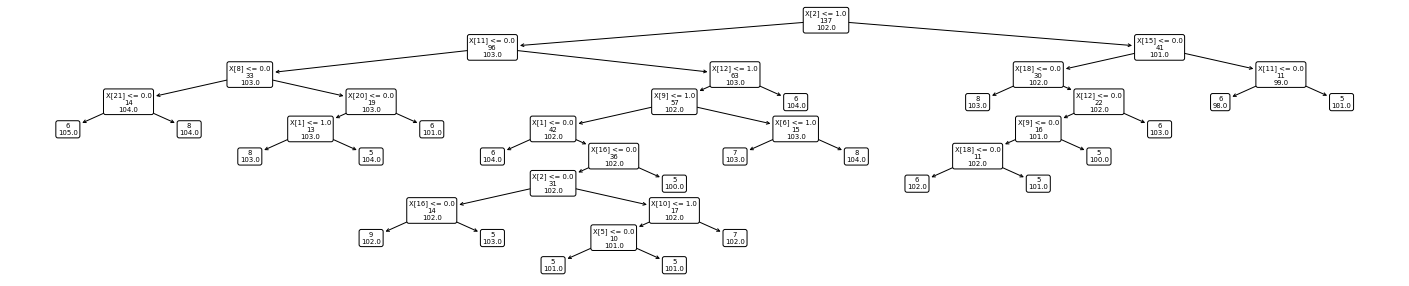

In [105]:
# **************************************
# **************************************
# SUPER LONG PROCESSING TIME!!
# **************************************
# **************************************

trees = best_grid.estimators_

fig, ax = plt.subplots(1, 1, figsize=(25,5))
tree.plot_tree(
    trees[0],
    #max_depth=4,
    #feature_names = X.columns, # labels the feature the each node is making a decision on
    rounded=True,
    impurity=False,
    label=None,
    ax=ax,
    precision=0
);


For a better visualisation I choose to display the feature importance of each feature.

In [106]:
# Check the accuracy
#print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

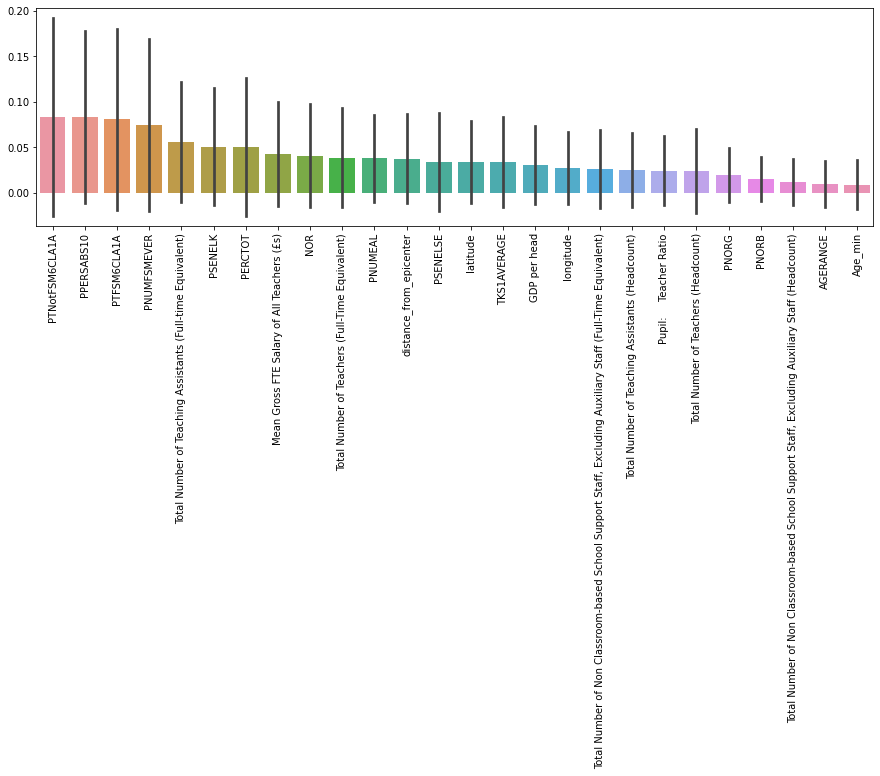

In [107]:
trees = best_grid.estimators_
feature_importances = pd.DataFrame(index = X.columns) # dataframe to store the feature importances

for i in range(len(trees)):
    col_name = "tree_" + str(i)
    feature_importances[col_name] = trees[i].feature_importances_

# now I find the mean feature importance for each feature
tree_names = feature_importances.columns
feature_importances['mean_feature_importance'] = feature_importances[tree_names].mean(axis=1)

feature_importances = feature_importances.sort_values(by=['mean_feature_importance'], ascending=False)

feature_importances = feature_importances.drop('mean_feature_importance', axis=1)

# plot the mean feature importances
fig, ax = plt.subplots(1,1,figsize=(15,4))
sns.barplot(
    data=feature_importances.T, 
    ax=ax,
    ci="sd" # include standard deviation error bars
)
# rotate the x-axis labels by 90 degrees
ax.set_xticklabels(rotation=90, labels=feature_importances.index);

As can be seen in the above visualisation, all features contribute where most are below 0.05. This indicates that most features only marginally increase predictive accuracy for the random forest.

### Explainability

- A huge issue in artificial intelligence at the moment is explainability, known as XAI. 
- A lot of machine learning algorithms are classified as black box models. A black box model is a defined as a model that produces some output  𝑦  from some input  𝑥  without the user having knowledge of the internal workings of the model. 
- So, why should I trust a black box model if I don't know exactly why it behaves the way it does? This is a difficult question and in this section I will see two different approaches I can take to explain a black box model to make it easier to make sense of its behaviour.

## Local Interpretable Model-Agnostic Explanations (LIME)
- LIME is is an XAI approach
- I can try to explain why a given (local) outcome deviates from a target outcome.
- Lets suppose I have a model that produces some output  𝑦̂   for some input  𝑥 . Lime attempts to explain the output  𝑦̂   by peturbing the input  𝑥  slightly and attempts to predict how the model will respond to this perturbation. 
- So, LIME attempts to understand why the model behaves the way it does locally around  𝑥 . 
- Lets use lime to explain the random forest I trained.
- LIME's major draw back is that it is stochastic and can give a slightly different explaination on each run

#### Explain the 100th sample

prediction:  101.41285646474269
True value:  102.0


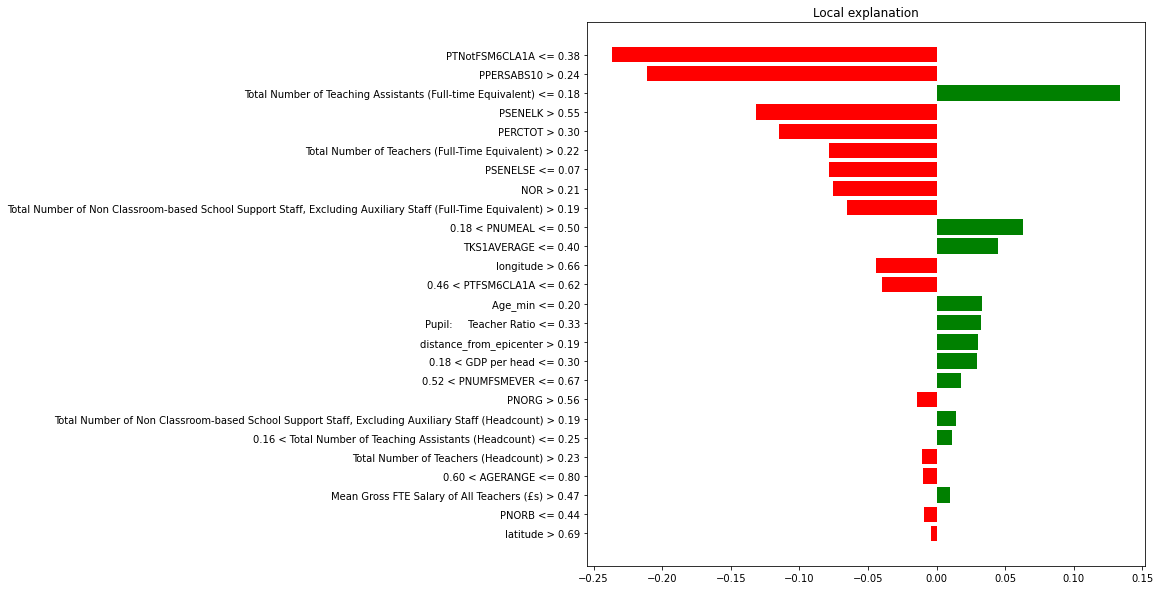

In [108]:
# create the lime explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values, # training data must be a numpy array
    feature_names=X_train.columns, 
    mode='regression'
)

# print y_hat and the true value of the 100th test example
y_hat = best_grid.predict([X_test.values[100]])[0]
print("prediction: ", y_hat)
print("True value: ", y_test.iloc[100])


# explain the 10th test example.
exp = explainer.explain_instance(X_test.values[100],best_grid.predict, num_features=100)

fig = exp.as_pyplot_figure()
fig.set_size_inches(10, 10)

See the true and predicted value of the 100-th sample in the test set. *Notice that the prediction was lower than the true value*

See an explanation of the deviation of the forecast from the target variable
It explains the error.
Listed on the left are the features in the data.
From top to bottom the features are ordered from most important to least important.
Green/Red color: features that have positive correlations with the target are shown in green, otherwise red.

Lets use lime to explain another test example.

prediction:  100.80027065878487
True value:  103.0


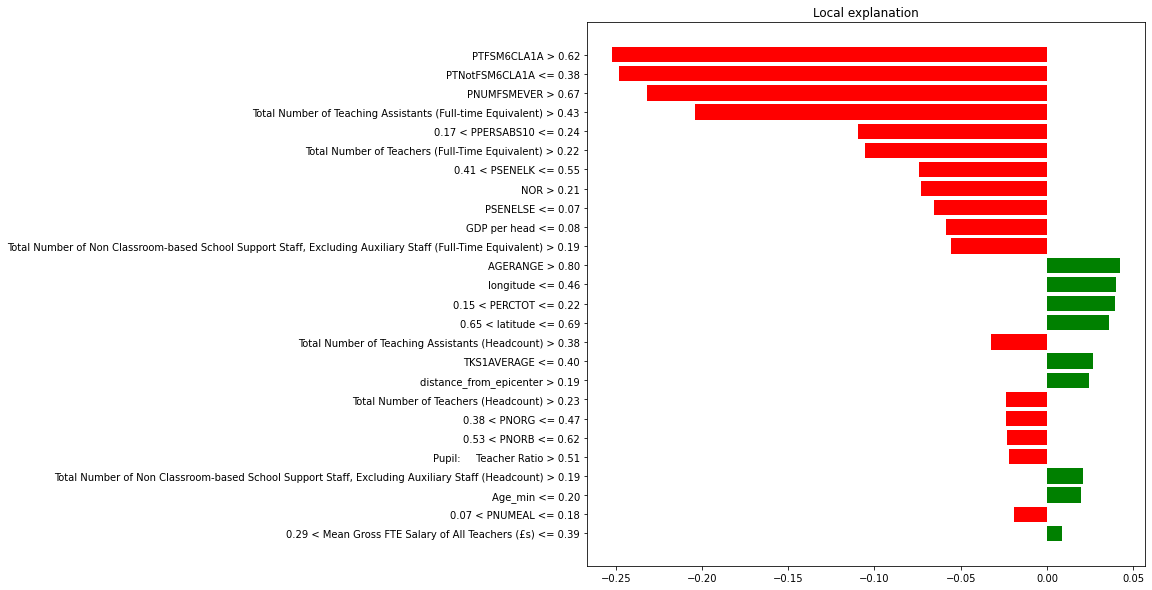

In [109]:
# print y_hat and the true value of the 15th test example
y_hat = best_grid.predict([X_test.values[15]])[0]
print("prediction: ", y_hat)
print("True value: ", y_test.iloc[15])

# explain the 10th test example.
exp = explainer.explain_instance(X_test.values[15],best_grid.predict, num_features=100)

fig = exp.as_pyplot_figure()
fig.set_size_inches(10, 10)

SHapley Additive exPlanations (SHAP)
SHAP is is another XAI approach

I can try to explain why a given (local) outcome deviates from a target outcome.
I consider each feature in a game theoretic context - as in Shapley values - to explain a models outcomes.
One of the main advantages that Shap has over Lime is that it attempts to explain the model throughout the global feature space as opposed to locally around one sample (although shap can also be used to explain individual samples).

SHAP is also deterministic approach, which means the results it generates on the same sample are always the same. 
The main disadvantage of Shap however is that it can take an age to run. The runtime of Shap is dependent on the complexity of model so I will run it on a much simpler random forest.

In [110]:
# limit the random forest to 400 decision trees with a maximum depth of 10
rf = RandomForestRegressor(criterion = 'mse', n_estimators = 400, max_depth=10)
rf.fit(X_train, y_train)
mse = mean_squared_error(y_test, rf.predict(X_test))
print("Test error: ", mse)

Test error:  3.3314986931655652


### Feature importance

- A feature of the sklearn implementation of randomforests is that it can generate it's own feature importance scores (and confidence intervals). 
- This can allow me to avoid out of the box XAI approaches, and allows me to run my own pertubations and sensitivity analysis.
- Lets take a  look at the feature importances for this new model before I use SHAP.


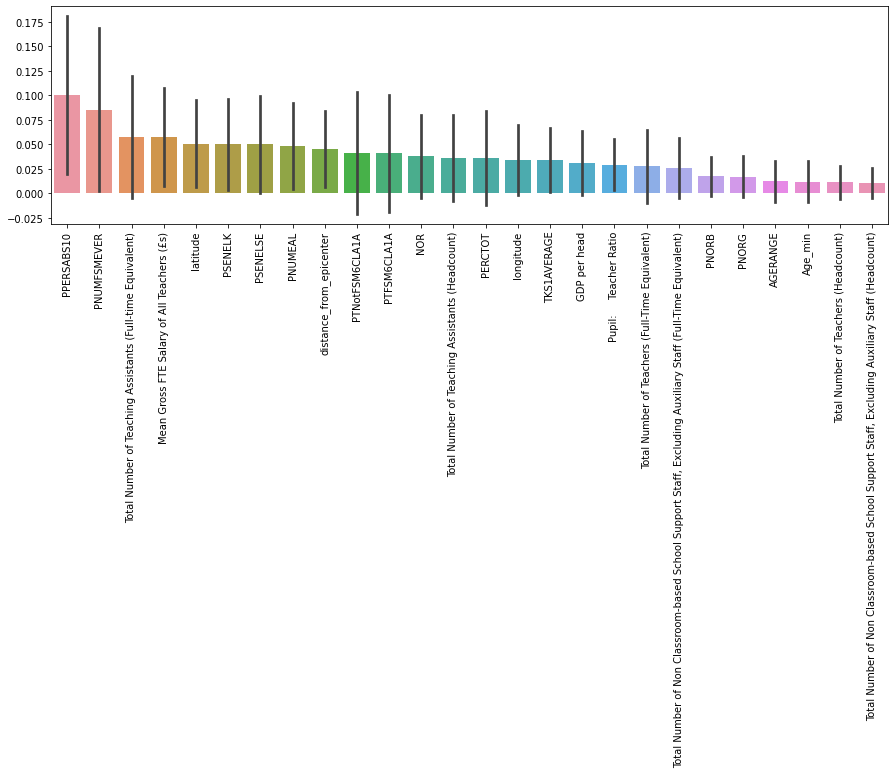

In [111]:
trees = rf.estimators_
feature_importances = pd.DataFrame(index = X.columns)

for i in range(len(trees)):
    col_name = "tree_" + str(i)
    feature_importances[col_name] = trees[i].feature_importances_

# now I find the mean feature importance for each feature
tree_names = feature_importances.columns
feature_importances['mean_feature_importance'] = feature_importances[tree_names].mean(axis=1)
feature_importances = feature_importances.sort_values(by=['mean_feature_importance'], ascending=False)
feature_importances = feature_importances.drop('mean_feature_importance', axis=1)

fig, ax = plt.subplots(1,1,figsize=(15,4))
sns.barplot(
    data=feature_importances.T, 
    ax=ax,
    ci="sd" # include standard deviation error bars
)
# rotate the x-axis labels by 90 degrees
ax.set_xticklabels(rotation=90, labels=feature_importances.index);

Now let us run Shap

### SHAP summary plots

- From top to bottom the features are ordered from most important to least important
- Shows the distribution of input variables by feature
- Red means a positive contribution made, blue dots mean a negative contribution made to the model outcome.
- For the score forecasting model, blue dots are lower scores
- X-axis was have the SHAP value. 

Eg: Look at *PPERSABS10*. The samples coloured red tend to have a positive shap value. This means that a high *PPERSABS10* is assosciated with a positive SHAP value and therefore a higher average score.

Now let us take a look at decision plots which show us feature contributions to an outcome. 

In [112]:
# **************************************
# **************************************
# SUPER LONG PROCESSING TIME!!
# **************************************
# **************************************

# create an explainer for the random forest model
explainer = shap.TreeExplainer(rf)

# calculate the shap values for X_test
shap_values = explainer.shap_values(X_test)

Now lets us plot a summary plot

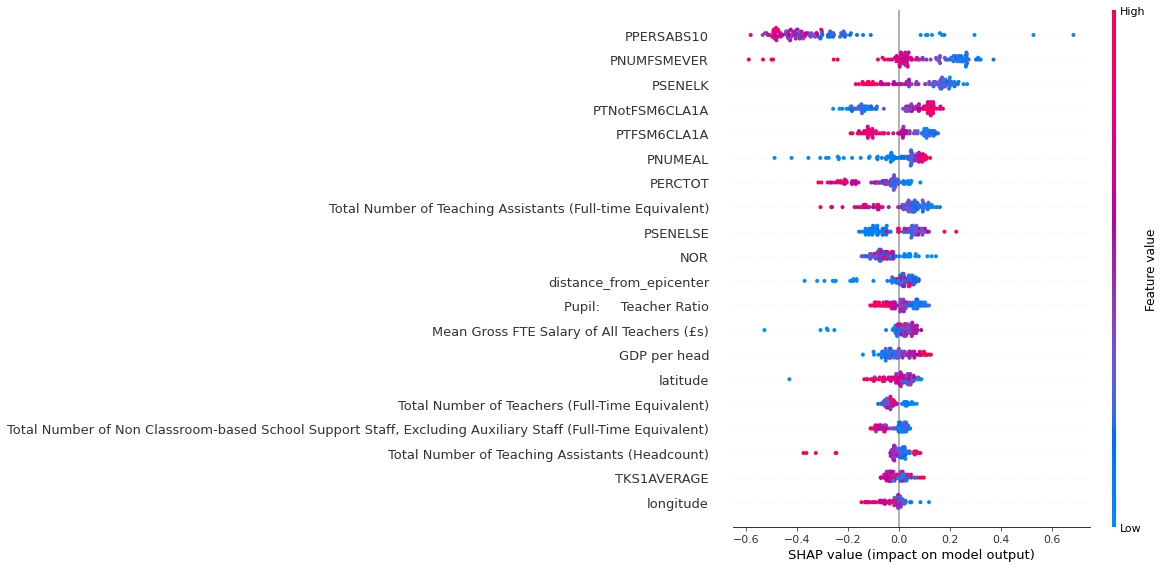

In [117]:
# Display summary
shap.summary_plot(shap_values,X_test)

Expected value of the model: [102.33548206]


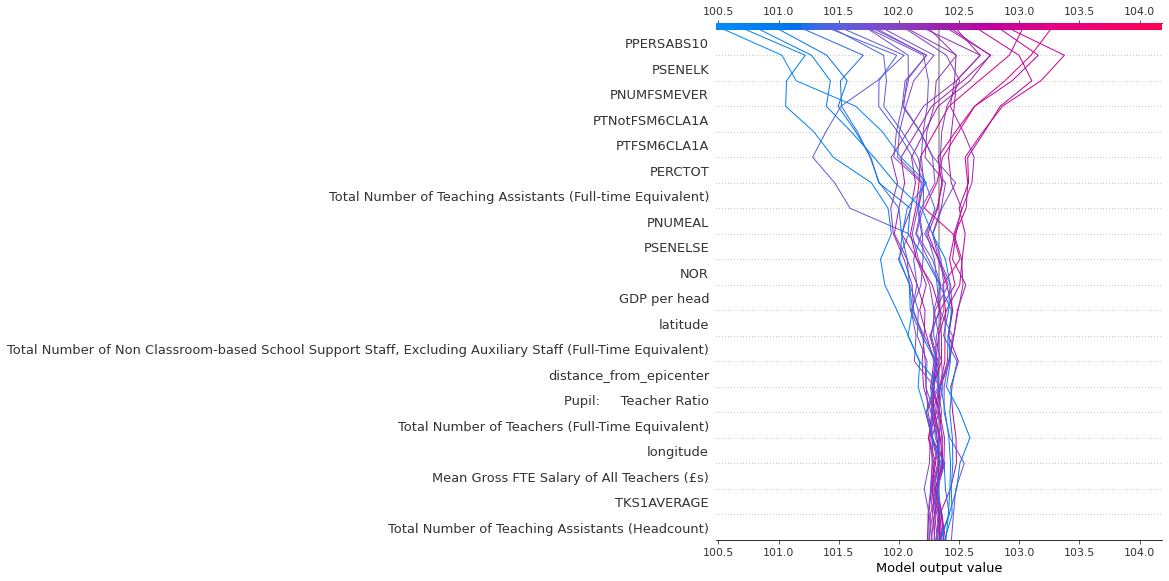

In [118]:
# Feature contributions
features = X_test.iloc[:25] #avoid the graph from being too crowded
expected_value = explainer.expected_value
shap_values = explainer.shap_values(features)
print("Expected value of the model:", expected_value)
shap.decision_plot(expected_value, shap_values, features)

Descion plots can be interpreted as follows:

- Each line represents an individual instance in the dataset
- The line terminates at the top, at the value forecast by the learner (that SHAP is trying to explain)
- The path the line takes from the bottom to the top shows the push and the pull of different features 
- The most important features are at the top, the least important at the bottom
- Note how the lines are forced left and right. 
- A move left means the forecast is forced down (by the left hand feature)
- A move right means the forecast is forced up (by the left hand feature)

The numbers displayed give a solid idea as to what is going on in the black box of the randomforest but it is uncertain whether SHAP's explaination would cut it in a life and death decision making situation. 

But, to get a cursory understanding of a model, SHAP is very powerful but if one wants a good and consistent, intuitive explanations from a mission critical model, bespoke development of XAI is essential.

## Neural networks

In this section, I will implement a simple neural network in Pytorch to model the data. The network architeture uses is shown below.

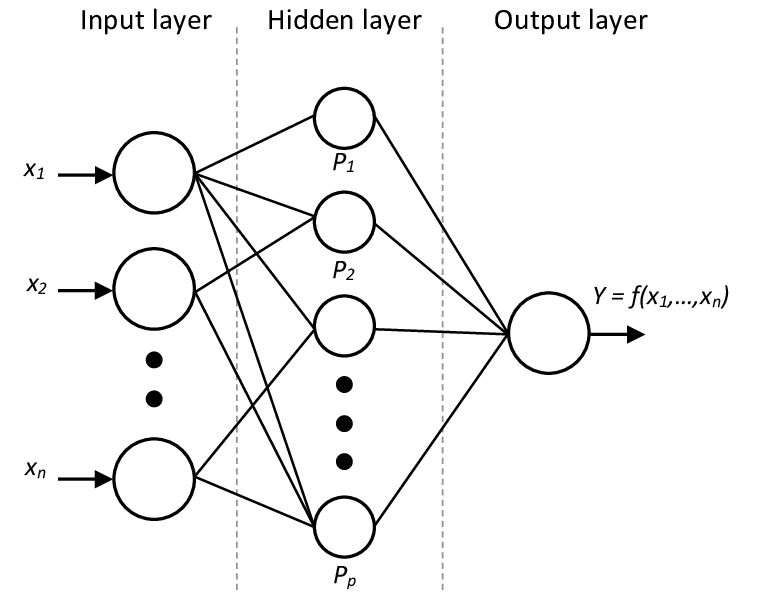<img src="Images\nn.png" width="300"> 

On the left I have 27 input notes that will represent each of the 27 independent variables. I have 19 nodes (The number of hidden neurons should be 2/3 the size of the input layer, plus the size of the output layer, https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw#:~:text=However%2C%20neural%20networks%20with%20two,more%20than%20one%20hidden%20layer.), in the hidden layer, and I have 1 out node in the output layer. In the ouput layer, I have one node which will give us the prediction for the dependent variable. 

I also induce try to optimse the parameters by using gradient loss (dloss).

I will implement the neural network using PyTorch. PyTorch is a fantastic deep learing library. More information on Pytorch may be found in the *Readme* file

In [119]:
# I use the sequential function
model = torch.nn.Sequential(
    torch.nn.Linear(26, 19),   # input layer
    torch.nn.ReLU(),           # activation function for the input layer
    torch.nn.Linear(19, 1)    # Hidden layer
)

In [120]:
# I must convert the data into pytorch tensors which are similar to numpy arrays.
X_train_tensor = torch.from_numpy(X_train.values).float()
y_train_tensor = torch.from_numpy(y_train.values).float()
X_test_tensor = torch.from_numpy(X_test.values).float()
y_test_tensor = torch.from_numpy(y_test.values).float()

# An optimiser is a method of updating the weights of the model after each step
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

# Define mean squared error as the loss function I am trying to minimize
loss_fn = torch.nn.MSELoss()
loss_train_hist = []
loss_test_hist = []

epochs = range(300)
for epoch in epochs:
    # set any accumulated gradients from the previous step to zero
    optimizer.zero_grad() 
    
    # make a prediction on the training set
    y_hat = model(X_train_tensor) 
    
    # calculate the mean squared error between the prediction and true value
    loss_train = loss_fn(y_hat, y_train_tensor)
    
    loss_train.backward()  # calculate the gradients dloss/dw where w is a parameter in the model
    optimizer.step() # update the parameters the gradient according to dloss/dw
    
    # calculate the MSE on the test set
    with torch.no_grad():
        y_hat = model(X_test_tensor)
        loss_test = loss_fn(y_hat, y_test_tensor)
        
    loss_train_hist.append(loss_train)
    loss_test_hist.append(loss_test)
        
    # print the loss every 25 epochs
    if (epoch % 5 == 0):
        print("Epoch %i  training error %f  test error %f" % (epoch, loss_train.item(), loss_test.item()))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning:

Using a target size (torch.Size([223])) that is different to the input size (torch.Size([223, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning:

Using a target size (torch.Size([110])) that is different to the input size (torch.Size([110, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Epoch 0  training error 10487.145508  test error 10397.826172
Epoch 5  training error 9554.185547  test error 8749.814453
Epoch 10  training error 794.106079  test error 84.180145
Epoch 15  training error 41.521259  test error 78.873123
Epoch 20  training error 38.586430  test error 73.621971
Epoch 25  training error 36.028969  test error 68.932976
Epoch 30  training error 33.795387  test error 64.737648
Epoch 35  training error 31.840279  test error 60.975296
Epoch 40  training error 30.124968  test error 57.593410
Epoch 45  training error 28.616419  test error 54.546711
Epoch 50  training error 27.286392  test error 51.795631
Epoch 55  training error 26.110592  test error 49.306126
Epoch 60  training error 25.068213  test error 47.048119
Epoch 65  training error 24.141308  test error 44.995434
Epoch 70  training error 23.314423  test error 43.125172
Epoch 75  training error 22.574265  test error 41.417114
Epoch 80  training error 21.909330  test error 39.853649
Epoch 85  training err

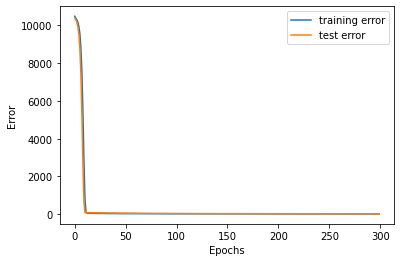

In [121]:
# Visualise the learning developments
plt.plot(epochs, loss_train_hist, label = 'training error')
plt.plot(epochs, loss_test_hist, label = 'test error')
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.legend()

Having run the neural network for 300 epochs, the best error I got from the neural network was still far worse than what I got with the random forest. Judging from the training curves above, training the network for more epochs likely would reduce the test error but perhaps not enough to justify the training time. The poor results from the neural network are not all that surprising since they are notoriously bad at modelling tabular data.

### SHAP summary plot

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning:

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.



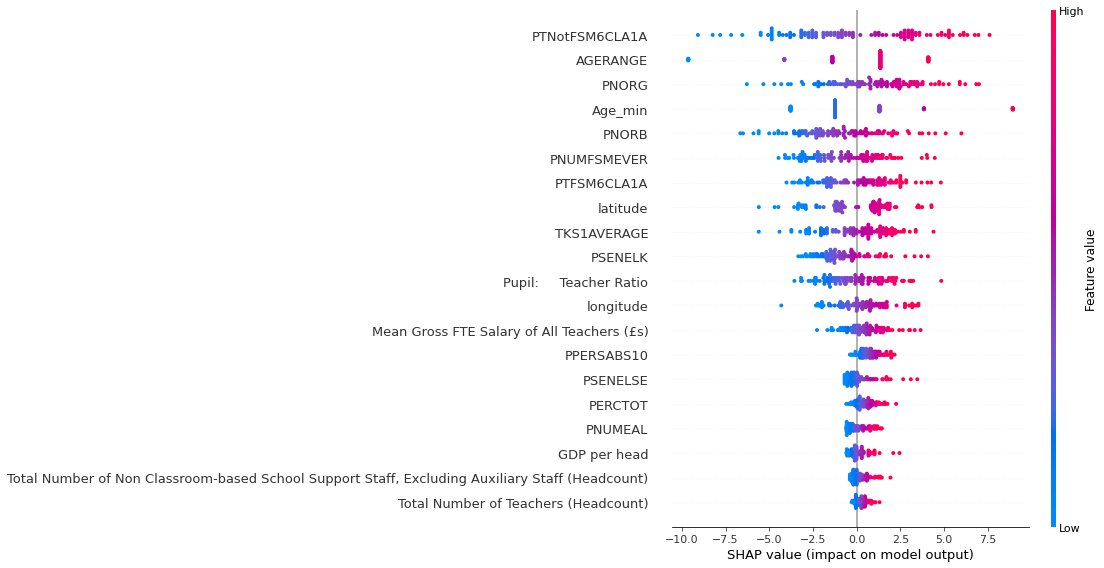

In [141]:
# explain predictions of the model
# Interpretation is congruent to RandomForest
e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(X_test_tensor)

# plot the feature attributions
shap.summary_plot(shap_values, X_test)

The shap summary indicates a fairly different distribution of the features when compared with the RandomForest. However, the explainability of the model remains a challenge even with the help of the SHAP as it remains unclear what exact weights have been used in the neural net. I thus infer that for this purpose the SHAP may not be useful and maybe of bigger help when i.e., classifying images. 

## Comparing model performance

In [245]:
print("Linear Regression")
# Prediction 100th sample linear regression
y_hat = rlm_res.predict([X_test.values[100]])[0]
print("prediction: ", y_hat)
print("True value: ", y_test.iloc[100])
print("-------")
print("Elastic net")

# Prediction 100th sample ElasticNet
y_hat = res.predict([X_test.values[100]])[0]
print("prediction: ", y_hat)
print("True value: ", y_test.iloc[100])
print("-------")
print("Random Forest")

# Prediction 100th RandomForest net
y_hat = best_grid.predict([X_test.values[100]])[0]
print("prediction: ", y_hat)
print("True value: ", y_test.iloc[100])
print("-------")
print("Neural net")

# Prediction 100th sample Neural Net
y_hat = model(X_train_tensor[100])[0]
print("prediction: ", y_hat)
print("True value: ", y_test.iloc[100])

Linear Regression
prediction:  98.40872590756615
True value:  102.0
-------
Elastic net
prediction:  101.05408694750695
True value:  102.0
-------
Random Forest
prediction:  101.41285646474269
True value:  102.0
-------
Neural net
prediction:  tensor(103.0518, grad_fn=<SelectBackward>)
True value:  102.0


Although the prediction capability based on one sample (in this case the 100th) is more illustrative than indicative it shows the differences in predictive capabilities. Where almost all the models predicted lower scores for the 100th sample the neural network predicted a higher one. Interestingly all models besides the Elastic Net where hardly off more than 1.

# 6) Results

The model with the best performance was the RandomForestRegressor with an MSE of 3.29 on the test sample. Even with 300 epochs the Neural Network didn't perform better. Additionally, the elastic net and the OLS didn't outperform it either with MSE scores of 3.35 and R2 of 0.340. Via hyperparameter tuning I tried to increase the robustness of the model but the gains were only marginal. The featues that contribute most are the absences of the students, the number of teaching assistants, teacher salary, and the number of pupil eligble for free school meals. Generally, speaking the predictive capabilities of the model could be better as the provided features do not allow for highly precise estimates. Therefore, its predictions ought to be considered carefully. Nevertheless, for the underlying task the model may offer interesting insights in terms of expected mathematics averages and may allow the firm to conducting some initial screening and filtering based on its results. 

## Relevance for business

Finally, the marketing departement will receive a detailed overview of the current situation at KS2 stage having a visual (geographical and regression) as well as predictive model at its disposal to start targeting schools. The predictive model that I developped utilises a variety of features to predict the mathematics average scores of schools in England (UK). The company, can hence use the model to predict such scores in schools all over the country to target them specifically. Schools with very low scores may be more attractive than ones with higher scores due to their need to invest more into their students abilities. They can be identified in advance using the model, helping the firm to identify trends in at KS2 level that might require shifts in terms of offerings or regions to target. In summary, the firm may capitalise on the model and the herein gained insights to target thus far uncovered schools and expand its market presence and share in England. 

# 7) Limitations

The herein described models have several limitations that ought to be considered when evaluating it. Firstly, the independent variables that were selected may not enable high predictability/ accuracy. Secondly, the data used considers only a year. To make more accurate predictions data from more years would need to be incorporated in future models. This might prove specifically interesting as it might reveal which schools have been underpforming and might thus be of interest (to be targeted for sales). Thirdly, the other models used besides the tree model (OLS, Elastic Net and Neural Nets) may suffer from longitude and latitude features as they cannot handle it as well. Fourthly, in a further step one may consider staking the models or combining them to achieve better predictability capabilities. Fifth, one may incorporate Shap.DeepExplainer to get visualise the details of the Neural Network (i.e., weights). Lastly, one may use bayesian optimisation instead of gridsearch to achieve better hyperparamters. In summary, these limitations ought to be considered when evaluating the predictive capability of the model. 

# 8) References

Benton, T. and Sutch, T., 2014. Analysis of use of key stage 2 data in gcse predictions. [online] Cambridge: University of Cambridge, pp.23- 32. Available at: <https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/429074/2014-06-16-analysis-of-use-of-key-stage-2-data-in-gcse-predictions.pdf> [Accessed 24 February 2021].

Bhandri, A., 2020. Feature Scaling | Standardization Vs Normalization. [online] Analytics Vidhya. Available at: <https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/> [Accessed 23 March 2021].

Brookings Institution, 2018. Brookings list of metropolitan economies in the United Kingdom. [online] Available at: https://www.brookings.edu/research/global-metro-monitor-2018/. [Accessed 18 March 2021]

Hand, D., Mannila, H. and Smyth, P., 2012. Principles of data mining. New Delhi: PHI Learning Private Limited.

Jadhav, C., 2017. Grade boundaries: the problems with predictions. [Blog] The Qfal Blog, Available at: <https://ofqual.blog.gov.uk/2017/02/03/grade-boundaries-the-problems-with-predictions/> [Accessed 24 February 2021].

Liu, M. and Vemuri, B., 2012. A Robust and Efficient Doubly Regularized Metric Learning Approach. Computer Vision – ECCV 2012, pp.646-659.

Malcolm, H., Wilson, V., Davidson, J. and Kirk, S., 2003. Absence from School: A study of its causes and effects in seven LEAs. [online] Department for Education and Skills. Available at: <https://core.ac.uk/reader/4158120> [Accessed 11 March 2021].

Office for National Statistics, 2020, Estimates of the population for the UK, England and Wales, Scotland and Northern Ireland. Office for National Statistics. Available at: https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/populationestimatesforukenglandandwalesscotlandandnorthernireland

Plass, J.L., Homer, B.D. and Kinzer, C.K., 2015. Foundations of game-based learning. Educational Psychologist, 50(4), pp.258-283.

Plass, J.L., O'Keefe, P.A., Homer, B.D., Case, J., Hayward, E.O., Stein, M. and Perlin, K., 2013. The impact of individual, competitive, and collaborative mathematics game play on learning, performance, and motivation. Journal of educational psychology, 105(4), p.1050.

Ray, S., 2015. How to Deal With Categorical Variable in Predictive Modeling. [online] Analytics Vidhya. Available at: <https://www.analyticsvidhya.com/blog/2015/11/easy-methods-deal-categorical-variables-predictive-modeling/> [Accessed 18 March 2021].

Strand, S., 2006. Comparing the predictive validity of reasoning tests and national end of Key Stage 2 tests: which tests are the ‘best’?. British Educational Research Journal, 32(2), pp.209-225.

Sutherland, A., Ilie, S. and Vignoles, A., 2015. Factors associated with achievement: key stage 2. [online] London: UK Department for Education, pp.10-25. Available at: <https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/473674/RR486_-_Factors_associated_with_achievement_-_key_stage_2.pdf> [Accessed 23 February 2021].

Velasco, K., 2019. Transforming categorical information into usable measures in a Machine Learning model. [online] Medium. Available at: <https://towardsdatascience.com/transforming-categorical-information-into-usable-measures-in-a-machine-learning-model-e2910bbb3fc7> [Accessed 18 March 2021].

Weale, S., 2021. Ofsted report says 200,000 pupils stuck in low achieving schools. The Guardian, [online] p.3. Available at: <https://www.theguardian.com/education/2020/jan/08/ofsted-report-says-200000-pupils-stuck-in-low-achieving-schools> [Accessed 23 February 2021].

Zou, H. and Hastie, T. (2004) Regularization and Variable
Selection via the Elastic Net. Journal of the Royal Statistical
Society, Series B. T
